# SETUP: GLOBALS AND GENERAL UTILS

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels as sm
# %matplotlib inline
pd.options.display.max_columns = None
def increase_figsize(N, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
def increase_size_by(N, fontsize, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
            
# Setting some default params. 
cbf = ['#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00']
cbf_map = mpl.colors.ListedColormap(cbf)
rc = {'axes.facecolor': 'white', 'axes.edgecolor': '.15', 'axes.axisbelow': True, 'figure.facecolor': 'white',
      'axes.labelcolor': '.15',  'text.color': '.25',
      'patch.force_edgecolor': True, 'patch.edgecolor': 'w',
      'xtick.bottom': True, 'ytick.left': True, 'xtick.color': '.15', 'ytick.color': '.15',
      'grid.linestyle': '-', 'axes.grid': False, 'grid.color': '.8', 
      'font.size': 30, 
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 
      'axes.titlesize': 22,
      'axes.labelsize': 15,
      'legend.fontsize': 18, 'legend.title_fontsize': 30,
      }
sns.set(rc=rc)
sns.set_palette(cbf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [63]:
def percentage(x): 
    return x / x.sum()

from pandas.core.base import PandasObject

PandasObject.set_columns = lambda df, values: df.T.set_index(values).T


In [61]:
has_header = True  # this can be made with the preprocessing file 'patches/remove_double_genomes.py' or 'patches/summary'
data_folder = '/home/hielke/bep/res/'
fig_folder = '/home/hielke/bep/figs/FOR_PUB/'
first_order = 'A'
second_order = 0
save = False
title_mod = ""
def save_fig(ax=None, save=save, plt=plt, title=None):
    if not save: 
        return 
    
    if not ax: 
        ax = plt.gca()
        
    title = title or (g.fig._suptitle._text 
                      if type(ax) is sns.axisgrid.FacetGrid 
                      else ax.get_title())
    
    global second_order
    second_order += 1
    
    dest = fig_folder + first_order + str(second_order) + "___" \
        + title.replace(" ", "_") + ".png"
    plt.savefig(dest, format='png', bbox_inches='tight')
    print("figure saved in " + dest)

# READ IN DATA

In [4]:
if has_header:
    df = pd.read_csv(data_folder + 'hits.tsv.header', sep='\t', 
                    index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str, 'spacer_pos': int, 'spacer_size': int}
                    ).set_index('genome_id')
else:
    df = pd.read_csv(data_folder + 'gene.matched.tsv.smallarraycheck', sep='\t', 
                 names=['genome_key', 'genome_id', 'contig_hit', 'c_1', 'c_2', 'spacer_id', 'hit_ident', 'spacer_size', 
                        'contig_size', '3_prime', '5_prime', 'array_id', 'array_size', 'array_confid', 'repeat_size', 'array_type', 'genome_type',
                        'PAM_confid', 'poss_PAM', 'PAM_side', 'phage_class', 'with_phage',  'gene_hit', 'gene_id', 'gene_class'],
                index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str}).set_index('genome_id')
df.drop(['3_prime', '5_prime', 'genome_key',], axis=1, inplace=True)
df.head()

,contig_hit,c_1,c_2,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,spacer_pos,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,JQGS01000037,11782,11751,JQGS01000065_1_1,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGCTAAAG,3,2,2,RNA+,JQGS01000037_19,UNKNOWN,1,0.000000,leader
100053.4,JQGS01000037,13121,13089,JQGS01000134_1_4,100.00,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,2,AGGAACTCAT,3,2,2,RNA+,JQGS01000037_20,UNKNOWN,4,0.750000,middle
100053.4,JQGS01000037,1789,1757,JQGS01000065_1_2,100.00,33,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTGAATCCG,3,2,2,INTERGENIC,NULL,NULL,2,0.090909,middle
100053.4,JQGS01000037,22144,22112,JQGS01000134_1_5,96.97,33,53765,JQGS01000134_1,5,3.02,28,NA,CAS-TypeIE,0,ATTTCGAGGT,3,2,2,RNA-,JQGS01000037_36,UNCLASSIFIED,5,1.000000,tail
100053.4,JQGS01000037,24519,24550,JQGS01000065_1_12,100.00,32,53765,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,3,CTTCGAATTC,3,2,2,RNA+,JQGS01000037_38,UNCLASSIFIED,12,1.000000,tail


In [5]:
def seq_iter(filehandle):
    for seq_id in filehandle:
        yield seq_id.strip()[1:], next(filehandle).strip()
spacers = seq_iter(open(data_folder + 'all_spacers.fna.hits'))
all_seq = pd.DataFrame(spacers, 
                     columns=['spacer_id', 'seq'])
all_seq.head()

,spacer_id,seq
0,JQGS01000134_1_2,TGTCATAGATTCGGACAAAACAATTGCTTTTAC
1,JQGS01000134_1_3,GAATTCACCGGAGGGCCTGACGAAGATTCACAA
2,JQGS01000134_1_4,GTATTTTTCAATGATTATCTTTATGGATTCAGG
3,JQGS01000134_1_5,GGCGGATATAATTTGAAGATGAGTAACATTGAA
4,JQGS01000065_1_1,GATCATTTCTTTATTCTCTGCGAGGAGCATAT


In [6]:
df_genome_class = pd.read_csv(data_folder + 'genome.types.tsv', sep='\t', 
                              names=['genome_id', 'type', 'class', 'num_genes'], 
                              dtype={'genome_id': str, 'num_genes': int}).set_index('genome_id')
df_genome_class.head()

,type,class,num_genes
genome_id,,,
100053.4,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11
100053.5,CAS-TypeIE,SingleUnknownExtra,8
100053.6,CAS-TypeIE,SingleUnknownExtra,8
100053.7,CAS-TypeIE,SingleUnknownExtra,8
100053.8,CAS-TypeIE,AccompaniedSingleUnknown,8


In [7]:
df_crispr = pd.read_csv(data_folder + 'spacers.info.tsv', sep='\t', 
                        names=['contig', 'array_id', 'start', 'end', 'ori', 'size', 'type', 'conf', 'repeat',],
                               keep_default_na=False)
df_crispr.head()

,contig,array_id,start,end,ori,size,type,conf,repeat
1324264.3,JLXT01000011,JLXT01000011_1,0,684,Reverse,9,NA,3.18,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000009,JLXT01000009_1,947496,948851,Reverse,18,NA,3.24,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000010,JLXT01000010_1,56,1186,Reverse,15,NA,3.20,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1603886.3,BDIS01000038,BDIS01000038_1,5412,6343,Forward,14,NA,3.24,CAAGCTTATCAAGAAGGGTGAATGCTAATTCCCAGC
1633637.3,CZVQ01000157,CZVQ01000157_1,2,778,Forward,9,NA,3.26,GTGAGCATCGAACCAGTGTGGAATTTAAAC


# PATCHES AND ENHANCEMENTS
Other patches that have been applied can be found in the patches folder. (The summary contains all (and more) in one file.) To apply just `bash ../patches/summary` in the data/folder.

In [8]:
df = df.reset_index().merge(all_seq, how='left', on='spacer_id', validate='m:1').set_index('genome_id')

### Remove uninteresting duplicates

In [9]:
# Duplicates resulting from duplicates contigs (same spacer_id with same coords on different contig.)
# This will also remove duplicates genomes
df = df.reset_index().groupby(['spacer_id', 'c_1', 'c_2']).first().reset_index().set_index('genome_id')
# Remove double arrays (same seq, same hit, same array location)
df = df.reset_index().groupby(['seq', 'c_1', 'c_2', 'contig_hit', 'spacer_pos']).first().reset_index().set_index('genome_id')

In [10]:
total_genomes = 110334
no_type = total_genomes - len(df_genome_class)  # There is also NOCAS in all_genome_types which is basically the same.
no_cas_no_selfhits = total_genomes - len(set(df.index)) - no_type  # Because of the above, this number is not correct.

### Specify some additional information

In [11]:
df['array_ori'] = df['rel_spacer_pos'].apply(lambda x: {0: 'head', 1: 'tail'}.get(x) or 'mid')

### Split in certain groups

In [23]:
# Identity with hit cut-off
# Group with unique spacer hits

# df : df with hit cut-off 
# df_all : all rows
# df_uni : Unique spacers for a genome (with the hit cut-off)
# df_uni_all : All unique spacers

perc_ident = 90

df_uni = (
    df.reset_index()
    .groupby(['genome_id', 'seq']).first().reset_index()
    .set_index('genome_id')
)
df_all = df
df_uni_all = df_uni

df = df.query('hit_ident > @perc_ident')
df_uni = df_uni.query('hit_ident > @perc_ident')
perc_ident = '100%' if perc_ident == 100 else '>%d%%' % perc_ident

# TRYING TO MAKE CRISPR GROUPING

## DEFAULT GROUPING

In [12]:
df_single_type = df[~df['genome_type'].str.contains('/')]

In [13]:
import re
def megasplit(pattern, string):
    """Split with zero lenght
    https://stackoverflow.com/questions/29988595/python-regex-splitting-on-pattern-match-that-is-an-empty-string
    """
    splits = list((m.start(), m.end()) for m in re.finditer(pattern, string))
    starts = [0] + [i[1] for i in splits]
    ends = [i[0] for i in splits] + [len(string)]
    return [string[start:end] for start, end in zip(starts, ends)]

def sort_groups(group_type):
    if group_type == 'other':
        return 'MZ'
    if not group_type.startswith("CAS"):
        return "Z" + group_type
    return "-".join(megasplit(r'(?<=V|I)(?!V|I)', group_type))

In [14]:
df_genome = df.groupby(df.index).first()
df_genome['selfhit_count'] = df.groupby(df.index)['contig_hit'].agg('count')
df_genome_type_count = df_genome['genome_type'].value_counts()
all_genome_type_count = df_genome_class['type'].value_counts()
all_genome_type_count = all_genome_type_count[df_genome_type_count.index]
all_genome_type_count['NOCAS'] = no_type
all_genome_type_count['other'] = total_genomes - sum(all_genome_type_count)
df_genome_type_count['other'] = 0
df_genome_type_count = df_genome_type_count.reindex(index = sorted(df_genome_type_count.index))
all_genome_type_count = all_genome_type_count.reindex(index = sorted(all_genome_type_count.index))

In [15]:
all_genome_type_count

CAS                  7869.0
CAS-TypeI               9.0
CAS-TypeIA            148.0
CAS-TypeIA/B           19.0
CAS-TypeIA/B/C          1.0
CAS-TypeIA/B/D          8.0
CAS-TypeIA/B/U         90.0
CAS-TypeIA/C          251.0
CAS-TypeIA/C/U          1.0
CAS-TypeIA/D            7.0
CAS-TypeIA/U            2.0
CAS-TypeIB           2397.0
CAS-TypeIB/C          833.0
CAS-TypeIB/D            9.0
CAS-TypeIB/E            6.0
CAS-TypeIB/U            6.0
CAS-TypeIC           2397.0
CAS-TypeIC/D            3.0
CAS-TypeIC/E           90.0
CAS-TypeIC/E/F          8.0
CAS-TypeIC/F           88.0
CAS-TypeIC/U            4.0
CAS-TypeID            180.0
CAS-TypeID/U            2.0
CAS-TypeIE          16074.0
CAS-TypeIE/F          218.0
CAS-TypeIE/U           20.0
CAS-TypeIF           4089.0
CAS-TypeIIA          2851.0
CAS-TypeIIA/B           4.0
CAS-TypeIIA/C          58.0
CAS-TypeIIB           205.0
CAS-TypeIIB/C           5.0
CAS-TypeIIC          2983.0
CAS-TypeIII            52.0
CAS-TypeIIIA        

## CUSTOM GROUPING

In [16]:
def new_type_group(row):
#     print(row)
    if row['num_genes'] == 0:
        return "NOCAS"
    if "Unclassified" in row['class']:
        return "Uncomplete"
    if "MultipleConfirmed" in row['class']:
        return "Confirmed Mixed"
    if "/" in row['type'] or row['type'] == "CAS": 
        return "Mixed"
    return row['type']
#     if "Confirmed" in row['class']:
#         return "Confirmed " + row['type']
#     if "Accompanied" in row['class']:
#         return "Accompanied " + row['type']
    
df_genome_class['new_type_group'] = df_genome_class.apply(new_type_group, axis=1)

In [17]:
df = df.join(df_genome_class)
df_genome_class[['new_type_group']].head()

,new_type_group
genome_id,
100053.4,CAS-TypeIE
100053.5,CAS-TypeIE
100053.6,CAS-TypeIE
100053.7,CAS-TypeIE
100053.8,CAS-TypeIE


In [18]:
alltypes_renamed_count = df_genome_class['new_type_group'].value_counts()
dftyped_renamed = df.groupby(by='genome_id').first()
dftyped_renamed['selfhit_count'] = df.groupby(by='genome_id')['contig_hit'].agg('count')
dftyped_renamed_count = dftyped_renamed['new_type_group'].value_counts()
print(alltypes_renamed_count)
alltypes_renamed_count = alltypes_renamed_count[dftyped_renamed_count.index]
alltypes_renamed_count['NOCAS'] += no_type
other = 'other'  # *can* include: {'CAS-TypeVC': 1, 'CAS-TypeVIB2': 2}
alltypes_renamed_count[other] = total_genomes - sum(alltypes_renamed_count)
dftyped_renamed_count[other] = 0
dftyped_renamed_count = dftyped_renamed_count.reindex(index=sorted(dftyped_renamed_count.index, key=sort_groups))
alltypes_renamed_count = alltypes_renamed_count.reindex(index=sorted(alltypes_renamed_count.index, key=sort_groups))

CAS-TypeIE         15342
CAS-TypeIIIA       10035
Uncomplete          5627
CAS-TypeIF          3390
NOCAS               3035
CAS-TypeIIC         2983
CAS-TypeIIA         2844
CAS-TypeIC          2384
CAS-TypeIB          2341
Mixed               2033
Confirmed Mixed      683
CAS-TypeIU           262
CAS-TypeIIIB         250
CAS-TypeIIB          205
CAS-TypeIV           189
CAS-TypeIIID         155
CAS-TypeIA           135
CAS-TypeID           107
CAS-TypeVA            71
CAS-TypeVIA           53
CAS-TypeVIB1          34
CAS-TypeVB            15
CAS-TypeIIIC          12
CAS-TypeVIB2           2
CAS-TypeVC             1
Name: new_type_group, dtype: int64


In [19]:
alltypes_renamed_count

CAS-TypeIA           135
CAS-TypeIB          2341
CAS-TypeIC          2384
CAS-TypeID           107
CAS-TypeIE         15342
CAS-TypeIF          3390
CAS-TypeIU           262
CAS-TypeIIA         2844
CAS-TypeIIB          205
CAS-TypeIIC         2983
CAS-TypeIIIA       10035
CAS-TypeIIIB         250
CAS-TypeIIIC          12
CAS-TypeIIID         155
CAS-TypeIV           189
CAS-TypeVA            71
CAS-TypeVB            15
CAS-TypeVIA           53
CAS-TypeVIB1          34
CAS-TypeVIB2           2
other                  1
Confirmed Mixed      683
Mixed               2033
NOCAS              61181
Uncomplete          5627
Name: new_type_group, dtype: int64

In [20]:
def insert_rows(df, idx, df_insert=None):
    if not df_insert: 
        df_insert = [0] * len(idx)
    df_insert = [pd.Series({"": i}) for i in df_insert]
    res = df.iloc[:idx[0], ]
    for i in range(len(idx) - 1):
        res = res.append(df_insert[i]).append(df.iloc[idx[i]:idx[i+1], ])
    res = res.append(df_insert[-1]).append(df.iloc[idx[-1]:, ])
    return res

# splits = [7, 10, 14, 15, 18, 21]
splits = [7, 10, 14, 15, 17, 19, 22]
dftyped_renamed_count = insert_rows(dftyped_renamed_count, splits)
alltypes_renamed_count = insert_rows(alltypes_renamed_count, splits)

# Top level plotting (Of STS in groups "NOCAS", "Uncomplete", "Mixed", "System")

In [21]:
df['top_level_group'] = df['new_type_group'].apply(lambda x: 'Mixed' if 'Mixed' in x else 
                                                  {k: k for k in ['NOCAS', 'Uncomplete']}.get(x) or 'CRISPR-Type')

# PLOTTING

### Change what grouping to use for coming plots

In [22]:
custom = True
if custom:
    df_genome_type_count = dftyped_renamed_count
    all_genome_type_count = alltypes_renamed_count
all_genome_type_count

CAS-TypeIA           135
CAS-TypeIB          2341
CAS-TypeIC          2384
CAS-TypeID           107
CAS-TypeIE         15342
CAS-TypeIF          3390
CAS-TypeIU           262
                       0
CAS-TypeIIA         2844
CAS-TypeIIB          205
CAS-TypeIIC         2983
                       0
CAS-TypeIIIA       10035
CAS-TypeIIIB         250
CAS-TypeIIIC          12
CAS-TypeIIID         155
                       0
CAS-TypeIV           189
                       0
CAS-TypeVA            71
CAS-TypeVB            15
                       0
CAS-TypeVIA           53
CAS-TypeVIB1          34
                       0
CAS-TypeVIB2           2
other                  1
Confirmed Mixed      683
                       0
Mixed               2033
NOCAS              61181
Uncomplete          5627
dtype: int64

In [24]:
def print_info(df):
    for identity_hit in [75, 90, 100]:
        q = 'hit_ident == 100' if identity_hit == 100 else 'hit_ident > @identity_hit'
        print("Total STS/genomes with STS (>%d): %d / %d" % (
            identity_hit, 
            len(df.query(q)),
            len(set(df.query(q).index))
            )
        )
        
print_info(df_all)

Total STS/genomes with STS (>75): 176215 / 22747
Total STS/genomes with STS (>90): 25495 / 9828
Total STS/genomes with STS (>100): 13751 / 7072


### Actual plots

Text(0.5, 1.0, 'Distribution of types of all genomes')

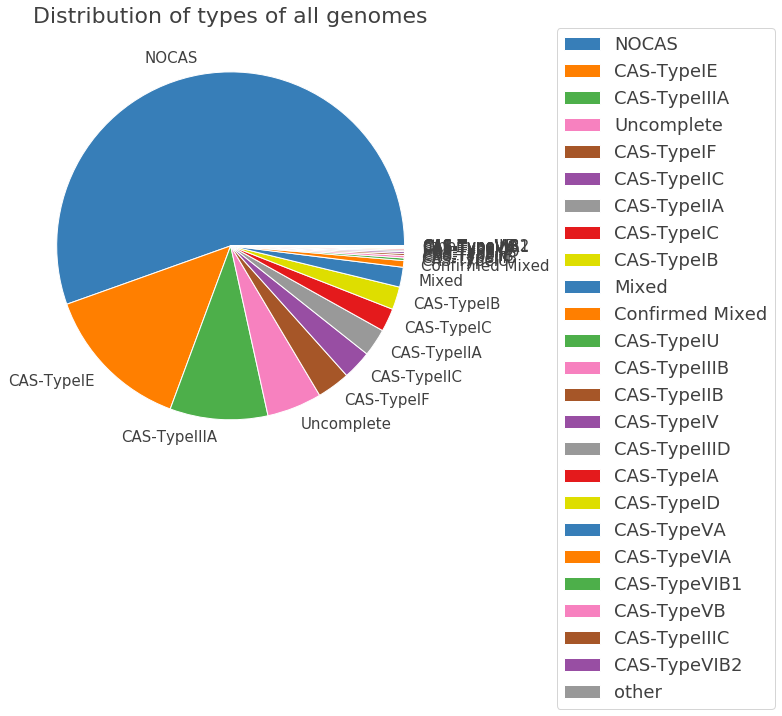

In [25]:
ax = all_genome_type_count[all_genome_type_count != 0].sort_values(ascending=False).plot.pie(legend=True)
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)
increase_figsize(2, plt)
ax.set_ylabel("")
ax.set_title("Distribution of types of all genomes")
# save_fig()

In [26]:
# ax = sns.countplot(x='spacer_size', data=df, color=cbf[0], saturation=100)
# # increase_figsize(3, plt)

# sns.despine()
# every_nth = 5
# for n, label in enumerate(ax.xaxis.get_ticklabels()):
#     if (n-1) % every_nth != 0:
#         label.set_visible(False)
# # ax.set_yscale('log')
# plt.title("Spacer size (all spacer hits)" + title_mod)
# plSize = plt.gcf().get_size_inches()
# plt.gcf().set_size_inches( (plSize[0]*1, plSize[1]*2) )
# if save:
#     second_order += 1
#     plt.savefig(fig_folder + first_order + str(second_order) + ax.get_title().replace(" ", "_") + ".png", format='png', bbox_inches='tight')

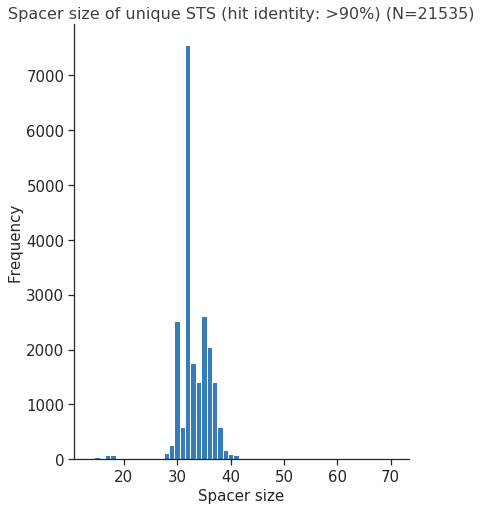

In [91]:
def plot(d):
    ax = d.pipe(
        lambda df: df['spacer_size'].hist(
            bins=list(map(.5 .__rsub__, range(df['spacer_size'].min(), df['spacer_size'].max() + 2)))
        )
    )
    return ax, len(d)
ax, N = plot(df_uni)
sns.despine()
ax.grid(False)
plSize = plt.gcf().get_size_inches()
plt.gcf().set_size_inches((plSize[0]*1, plSize[1]*2))
# ax.set_yscale('log')
plt.title("Spacer size of unique STS (hit identity: %s) (N=%d)" % (perc_ident + title_mod, N), fontsize=16)
plt.xlabel("Spacer size")
plt.ylabel("Frequency")
save_fig()

figure saved in /home/hielke/bep/figs/FOR_PUB/A2___Distribution_of_array_size_of_all_unique_STS_(hit_identity:_>90%).png


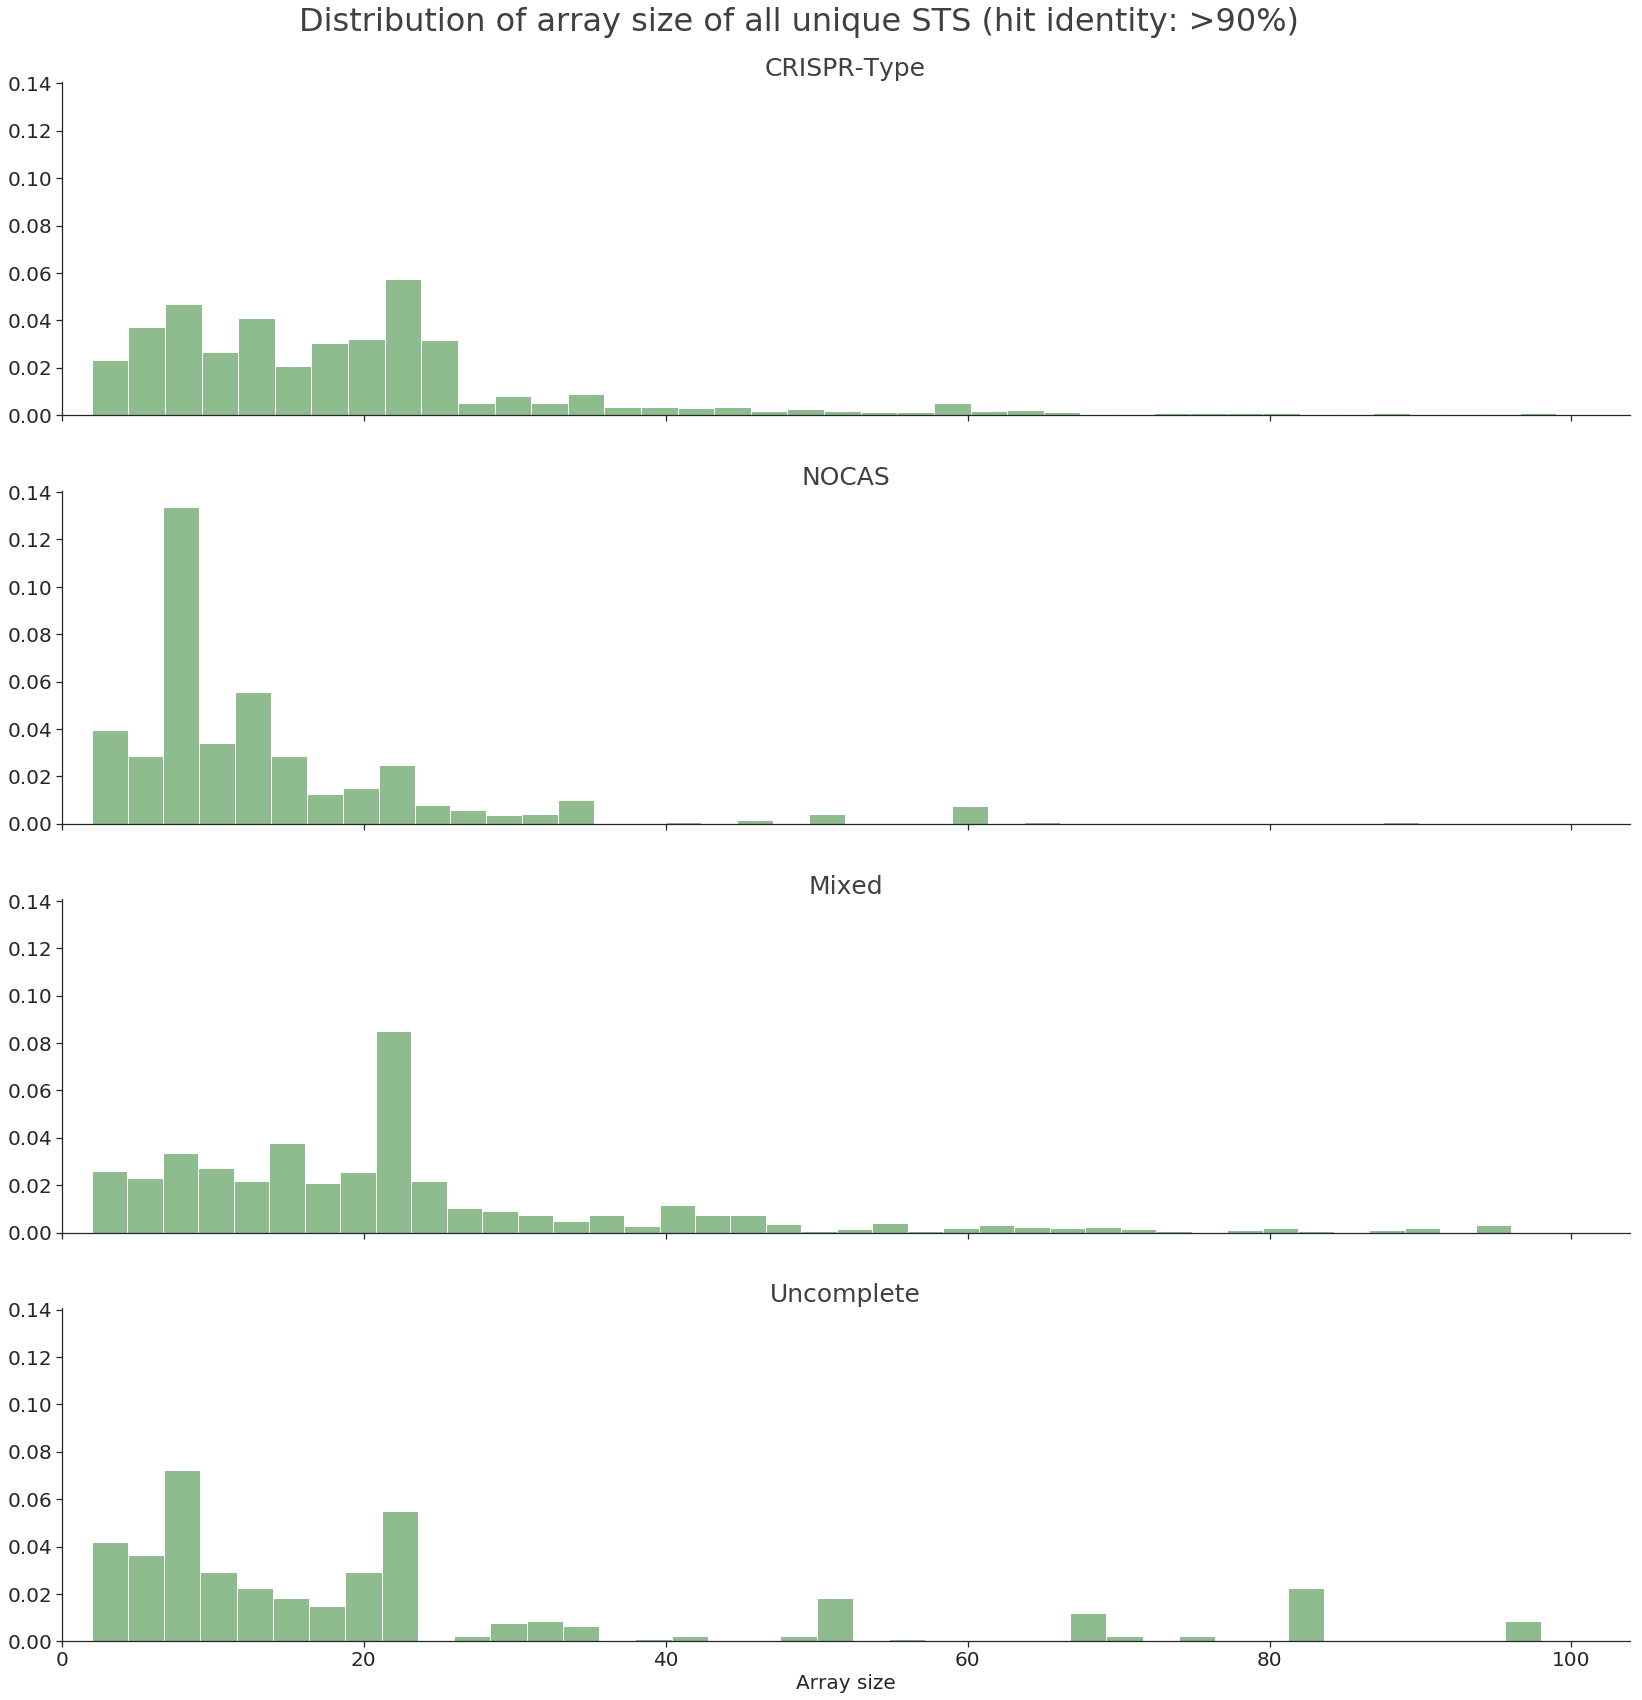

In [28]:
g = sns.FacetGrid(df_uni.query('array_size < 100'), row='top_level_group', aspect=4, ) 
g = g.map(plt.hist, 'array_size', density=True, color='darkseagreen', bins=40)
g.fig.suptitle("Distribution of array size of all unique STS (hit identity: %s)" % perc_ident, fontsize=32, y=1.01)
# ax.set_yscale('log')
plt.xlabel('Array size')
for ax in g.axes.flat:
    ax.set_xlim(left=0)
increase_size_by(2, 20)
g.set_titles(row_template="{row_name}", size=25)
save_fig(g)

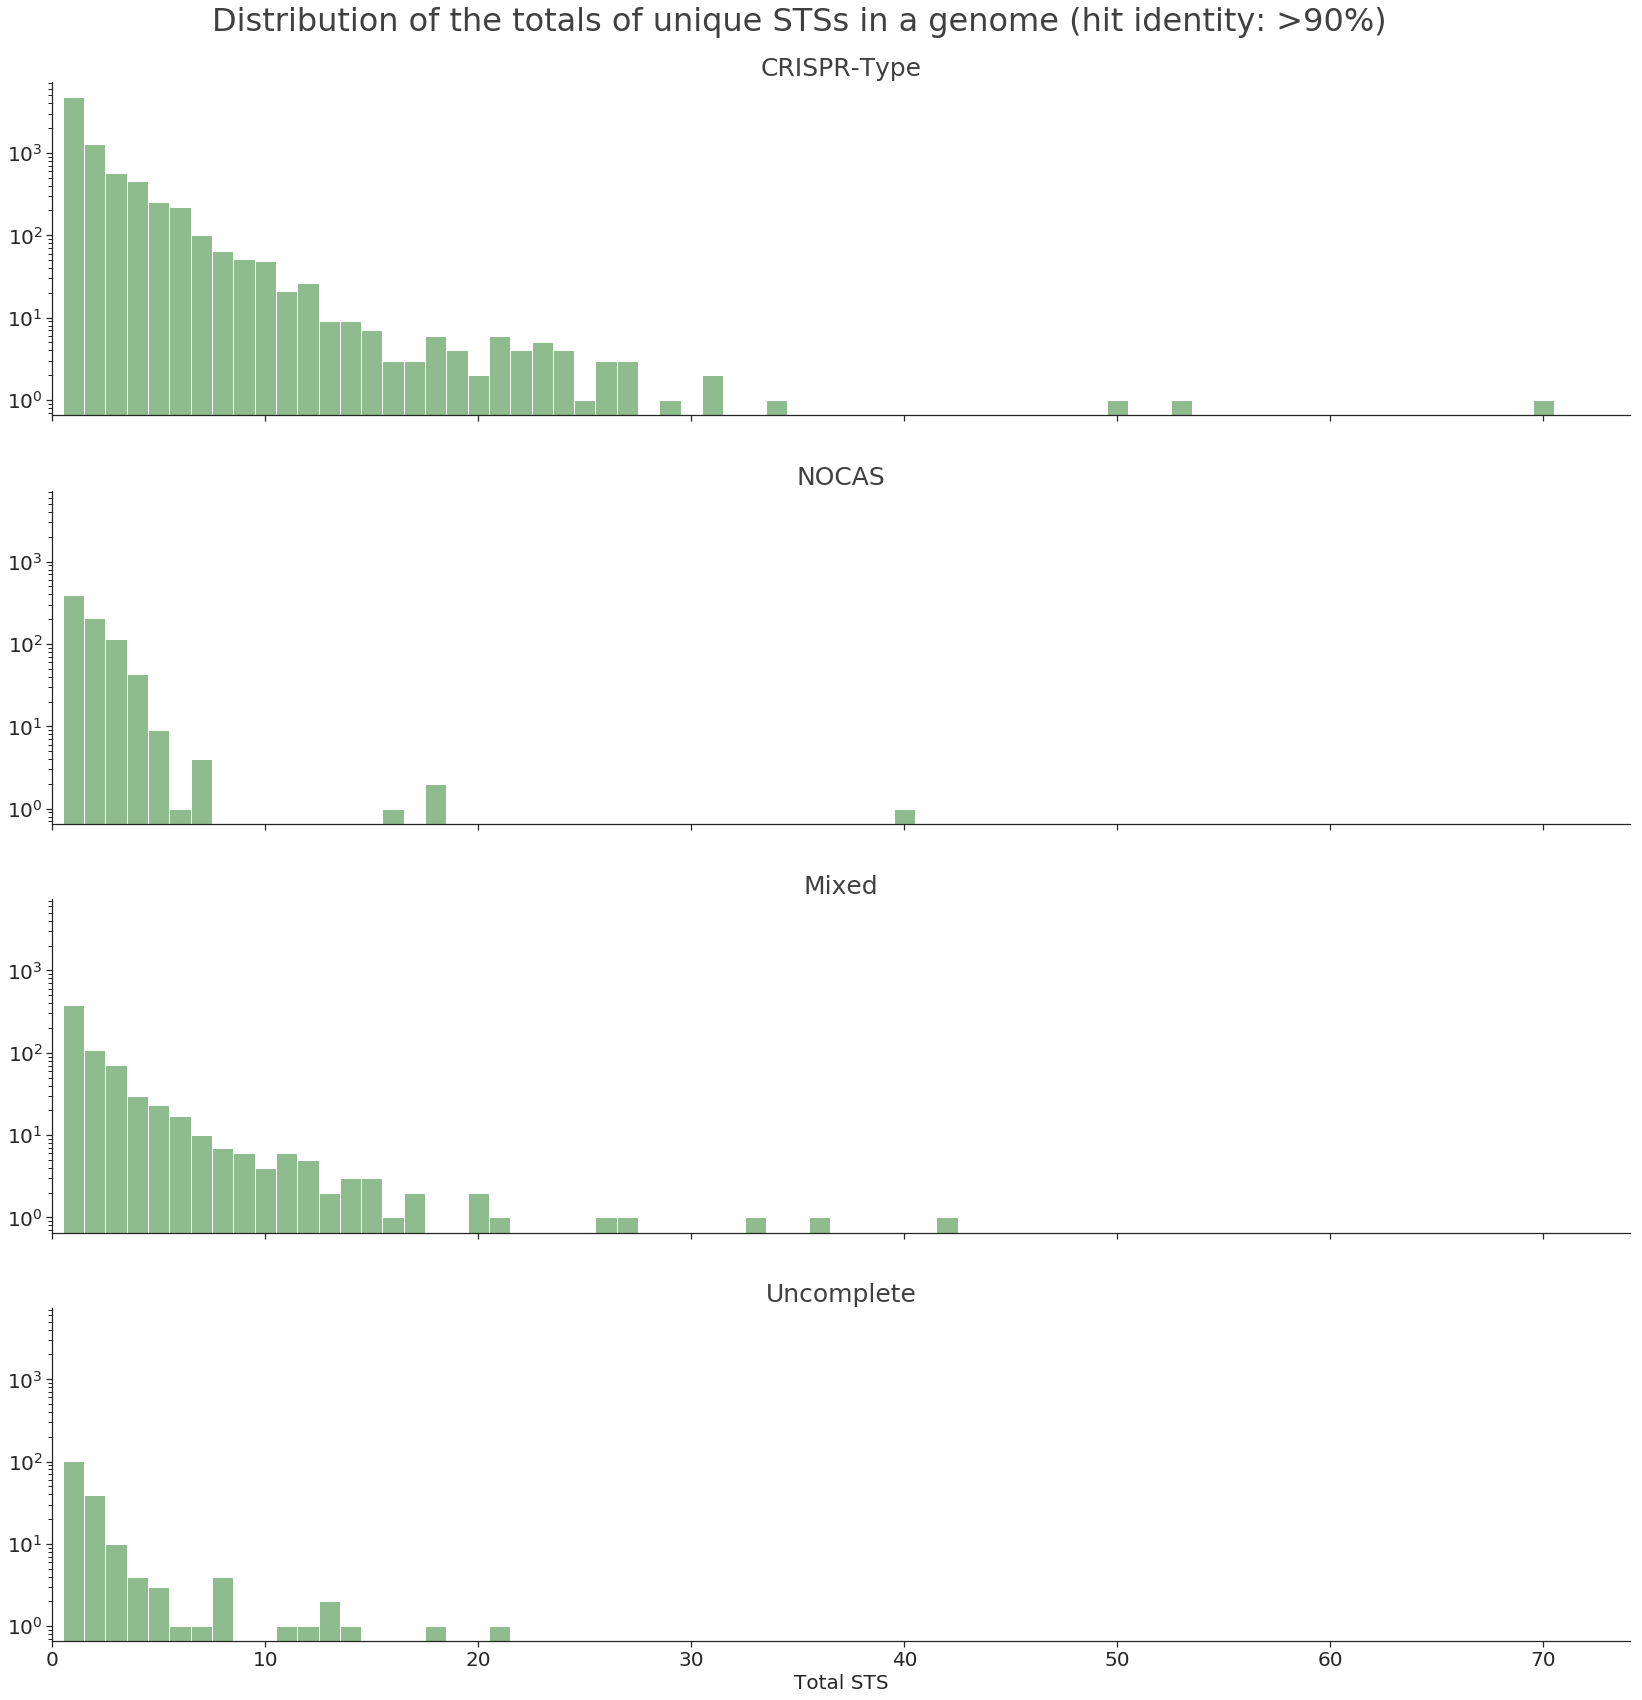

In [76]:
df_hitcount = df_uni.pipe(
    lambda df:
    df.groupby(by='genome_id').agg('first')
    .assign(
        genome_count_hit=df.groupby(by='genome_id')['array_id'].agg('count')
    )
)

g = sns.FacetGrid(df_hitcount, row='top_level_group', aspect=4, ) 
g = g.map(plt.hist, 'genome_count_hit', density=False, color='darkseagreen', 
          bins=list(map(.5 .__rsub__, range(0, df_hitcount['genome_count_hit'].max() + 2)))
         )

g.fig.suptitle("Distribution of the totals of unique STSs in a genome (hit identity: %s)" % perc_ident, fontsize=32, y=1.01)
plt.xlabel('Total STS')
g.set(yscale='log')
for ax in g.axes.flat:
    ax.set_xlim(left=0, )
increase_size_by(2, 20)
g.set_titles(row_template="{row_name}", size=25)
save_fig(g)

In [30]:
all_genome_type_count[all_genome_type_count.index != 'NOCAS']

CAS-TypeIA           135
CAS-TypeIB          2341
CAS-TypeIC          2384
CAS-TypeID           107
CAS-TypeIE         15342
CAS-TypeIF          3390
CAS-TypeIU           262
                       0
CAS-TypeIIA         2844
CAS-TypeIIB          205
CAS-TypeIIC         2983
                       0
CAS-TypeIIIA       10035
CAS-TypeIIIB         250
CAS-TypeIIIC          12
CAS-TypeIIID         155
                       0
CAS-TypeIV           189
                       0
CAS-TypeVA            71
CAS-TypeVB            15
                       0
CAS-TypeVIA           53
CAS-TypeVIB1          34
                       0
CAS-TypeVIB2           2
other                  1
Confirmed Mixed      683
                       0
Mixed               2033
Uncomplete          5627
dtype: int64

figure saved in /home/hielke/bep/figs/FOR_PUB/A4___Genomes_with_STSs_grouped_for_each_type.png


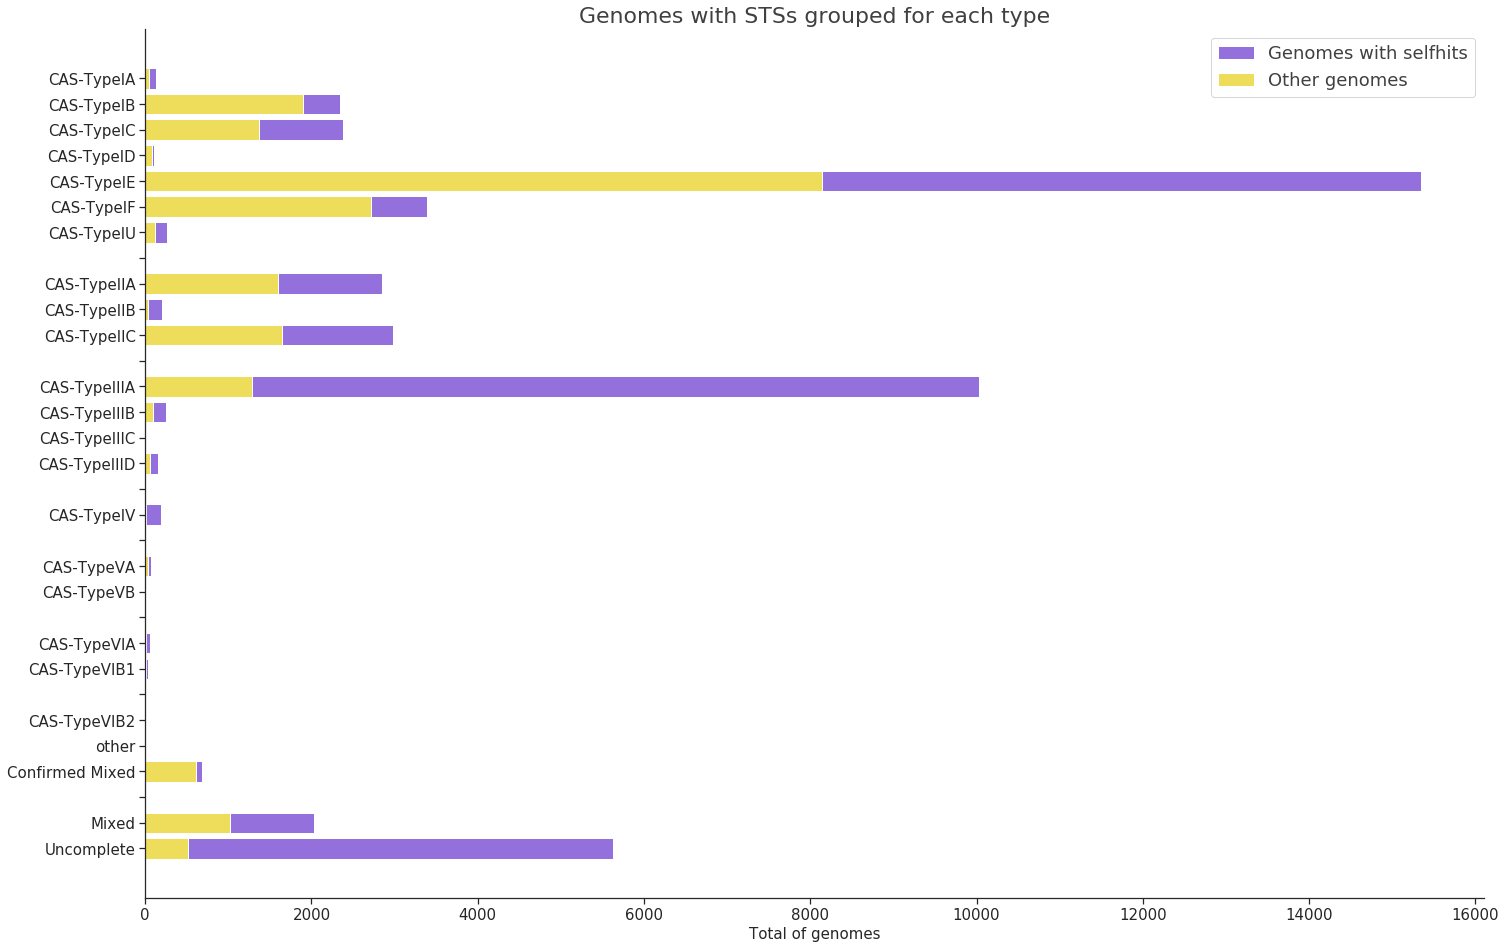

In [31]:
df_genome_type_count_subsection = df_genome_type_count[df_genome_type_count.index != 'NOCAS']
all_genome_type_count_subsection = all_genome_type_count[all_genome_type_count.index != 'NOCAS']

N = len(df_genome_type_count_subsection)

ind = list(range(N))[::-1]

plt.barh(ind, all_genome_type_count_subsection, color='mediumpurple', )
ax = plt.barh(ind, df_genome_type_count_subsection, color=sns.xkcd_rgb["dull yellow"], )

plt.yticks(ind, df_genome_type_count_subsection.index)
plt.legend(['Genomes with selfhits', 'Other genomes'], loc='upper right')
plt.title("Genomes with STSs grouped for each type")
plt.xlabel("Total of genomes")
# plt.gca().set_xscale('log')
sns.despine()
increase_figsize(4, plt, )
save_fig()

figure saved in /home/hielke/bep/figs/FOR_PUB/A1___Genomes_with_STSs_normalized_for_type_abundance_(hit_identity_>90%).png


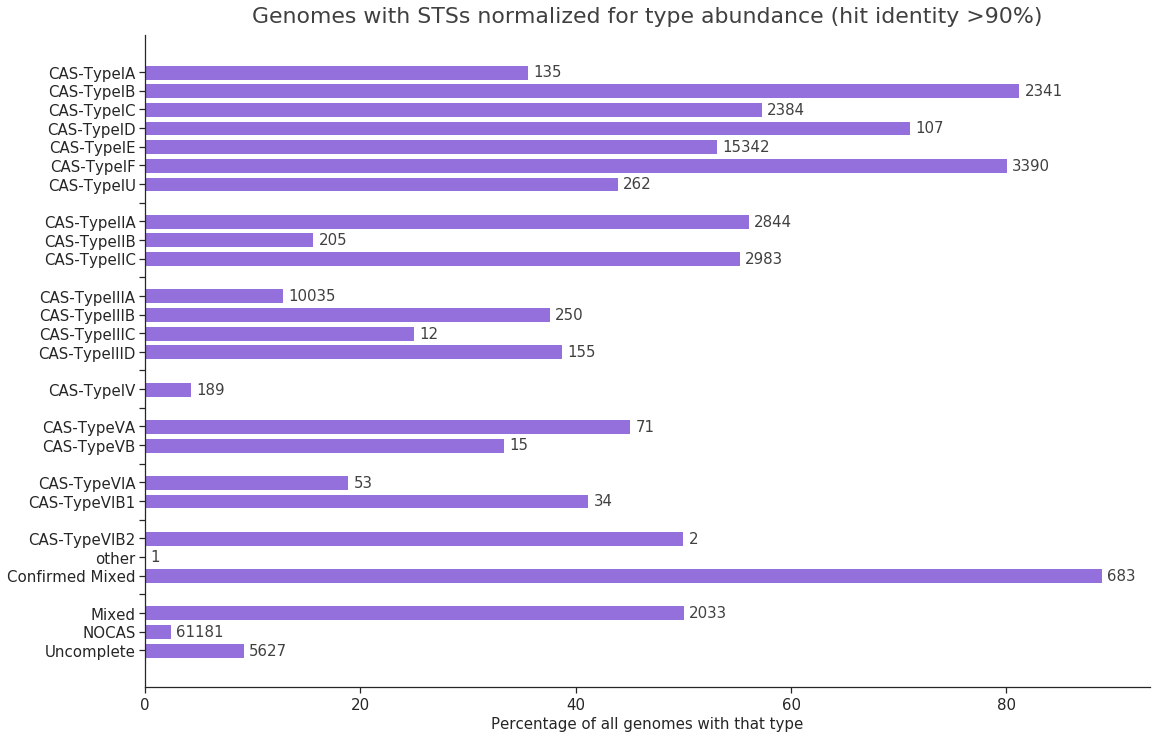

In [59]:
color="mediumpurple"
value_counts_perc = [(p / w * 100) if p != 0 else 0 for p, w in zip(df_genome_type_count, all_genome_type_count)]
N = len(df_genome_type_count)
ind = list(range(N))[::-1]
fig, ax = plt.subplots()    
plt.barh(ind, value_counts_perc, color=color)
plt.yticks(ind, df_genome_type_count.index)
for i, v in enumerate(all_genome_type_count):
    if v == 0: continue
    ax.text(value_counts_perc[i]+0.5, ind[i]-0.25, str(round(v)), color='0.25', fontsize=15)
plt.title("Genomes with STSs normalized for type abundance (hit identity %s)" % perc_ident, y=1.01)
plt.xlabel("Percentage of all genomes with that type")
sns.despine()
increase_figsize(3)
save_fig()

# PHAGE HIT

In [33]:
df_phage_retyped = df.pipe(
    lambda df:
    df.groupby(by='genome_id').first()
    .assign(
        phage_perc=df.groupby(by='genome_id')['with_phage'].agg(lambda x: sum(x==2)/len(x))
    )
)
df_phage_retyped.head()

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,array_ori,type,class,num_genes,new_type_group,top_level_group,phage_perc
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,AACTTCTTCTCCGTGGATTTCGTCGTCACCAT,10514,10484,JQGS01000075,2,JQGS01000093_1_2,96.875,32,17127,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CCTTTATGGA,3,3,2,RNA+,JQGS01000075_22,UNCLASSIFIED,0.045455,middle,mid,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type,0.833333
100053.5,CACATCCAACCCGAAGACTTGAGCATTCTTCA,1242,1273,JQGU01000091,22,JQGU01000025_1_22,100.000,32,16908,JQGU01000025_1,23,6.23,29,CAS-TypeIE,CAS-TypeIE,0,CTGGTTGGTG,3,NULL,0,RNA-,JQGU01000091_1,Protein of unknown function (DUF1564),0.954545,middle,mid,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,CRISPR-Type,0.000000
100053.6,GAGACAGATTCGAAGGAAACTTCAAAGACGAC,11287,11256,JQGV01000052,38,JQGV01000216_1_38,100.000,32,18548,JQGV01000216_1,51,6.26,29,CAS-TypeIE,CAS-TypeIE,0,CGTTCTTATA,3,NULL,0,RNA-,JQGV01000052_10,MORN motif,0.740000,middle,mid,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,CRISPR-Type,0.000000
100053.7,AAAACAGAATGGATTTTGACTTAAAACCCTAACCACTAATTCCTAA...,5644,5589,JQGT01000055,24,JQGT01000117_1_24,91.070,56,5671,JQGT01000117_1,24,6.16,29,CAS-TypeIE,CAS-TypeIE,3,CCATTCAACC,3,NULL,0,INTERGENIC,NULL,NULL,1.000000,tail,tail,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,CRISPR-Type,0.117647
100053.8,AAAACAGGATGGATTTTGATTTAAAACCCTAACCACTGATTCCTAA...,146,200,JQGW01000033,3,JQGW01000031_1_3,98.180,55,75992,JQGW01000031_1,3,5.25,29,CAS-TypeIE,CAS-TypeIE,3,CCATCCAACC,3,NULL,0,INTERGENIC,NULL,NULL,1.000000,tail,tail,CAS-TypeIE,AccompaniedSingleUnknown,8,CAS-TypeIE,CRISPR-Type,0.000000


Code below raises warning, but can't be fixed because of: 

https://github.com/pandas-dev/pandas/issues/18366

Check this link when the code below breaks to see the alternative syntax implemented in the pull request that will close the issue. 

/home/hielke/pydev/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


figure saved in /home/hielke/bep/figs/FOR_PUB/A5___Genomes_selfhits_in_(pro)phage_or_not_(hit_identity:_>90%).png


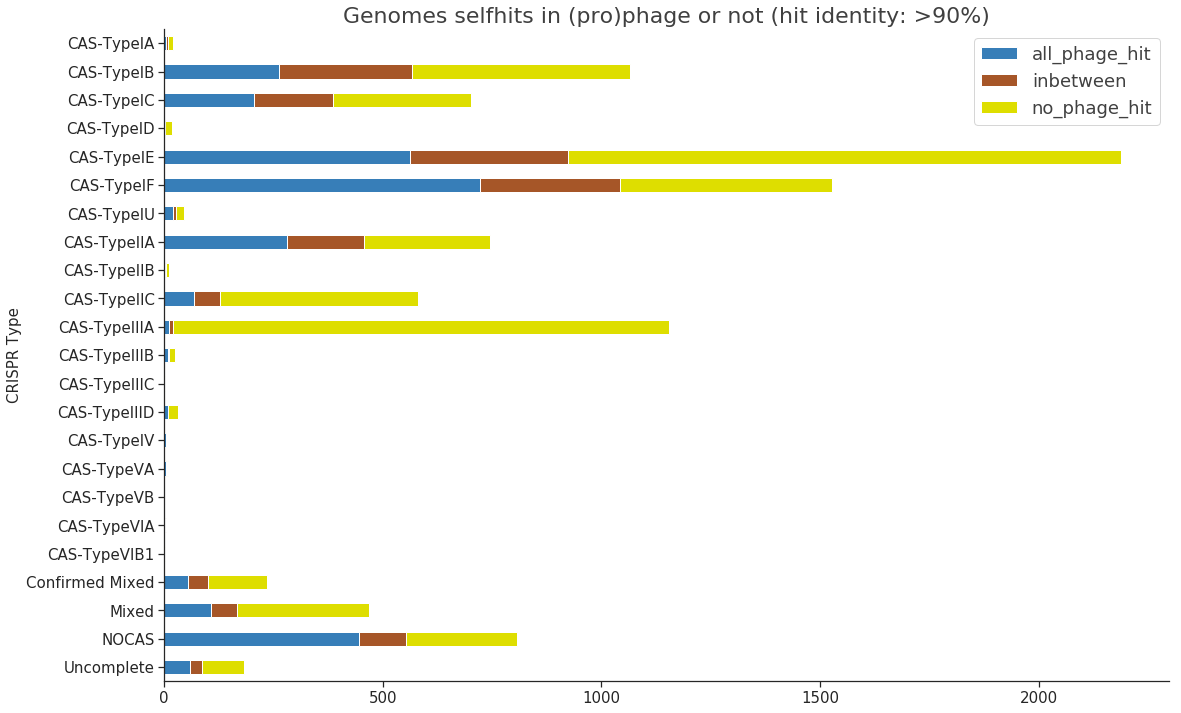

In [34]:
phage_hit_genome_level = df_phage_retyped.groupby("new_type_group") \
        ['phage_perc'].agg({"all_phage_hit": lambda x: sum(x==1.0), 
                                                                       "inbetween": 'count', 
                                                                       "no_phage_hit": lambda x: sum(x==0.0),
                                                                      })
phage_hit_genome_level['inbetween'] = phage_hit_genome_level['inbetween'] \
                                    - phage_hit_genome_level['all_phage_hit'] \
                                    - phage_hit_genome_level['no_phage_hit']
phage_hit_genome_level = phage_hit_genome_level.reindex(sorted(
    phage_hit_genome_level.index, key=sort_groups, reverse=True))
phage_hit_genome_level[['all_phage_hit', 'inbetween', 'no_phage_hit']] \
    .plot.barh(stacked=True, cmap=cbf_map)
sns.despine()
plt.title("Genomes selfhits in (pro)phage or not (hit identity: %s)" % perc_ident)
plt.ylabel("CRISPR Type")
increase_figsize(3)
save_fig()

figure saved in /home/hielke/bep/figs/FOR_PUB/A6___STSs_targeting_(pro)phage_normalized_for_type_abundance_in_selftargeting_genomes_(hit_identity:_>90%).png


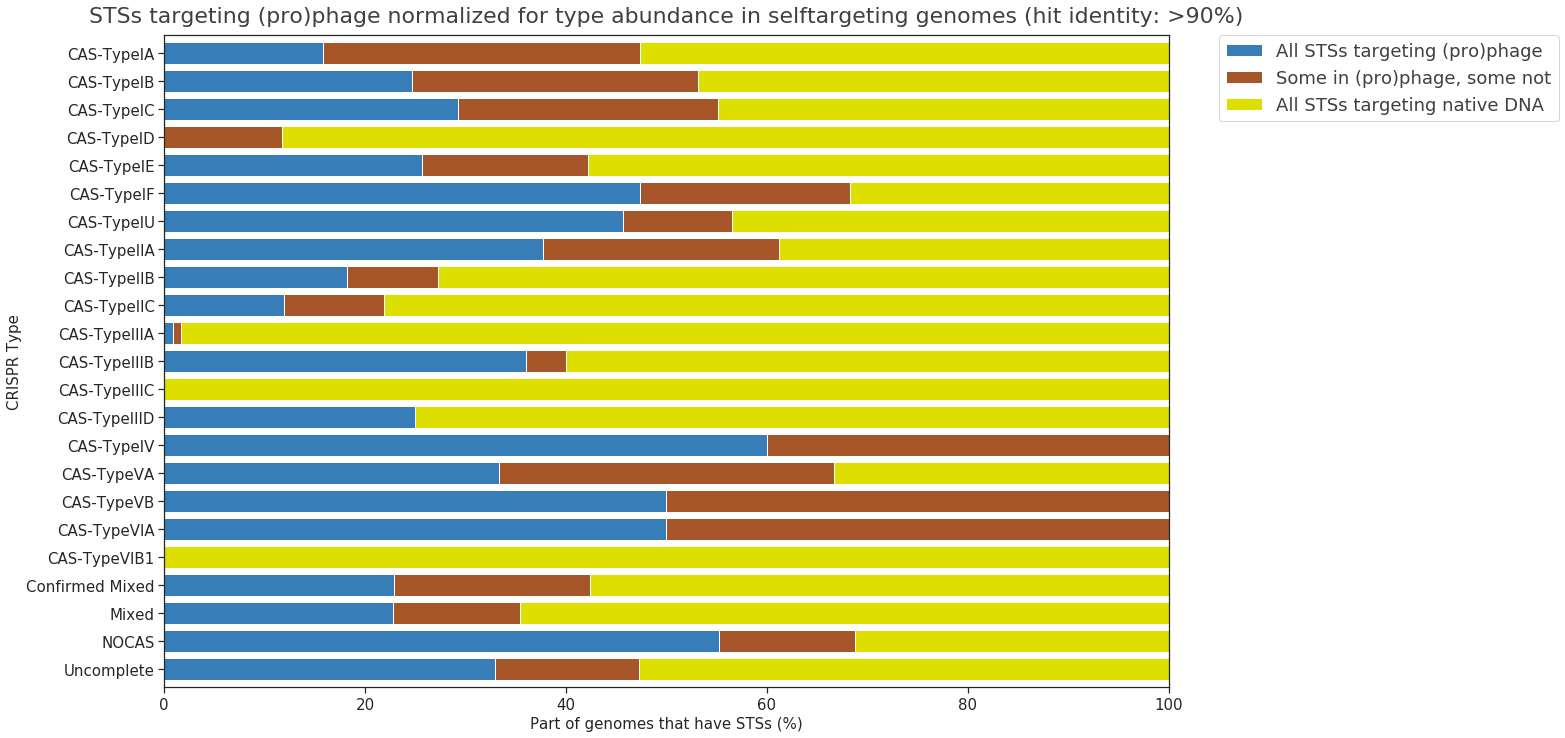

In [35]:
phage_hit_genome_level_percentage = phage_hit_genome_level.div(phage_hit_genome_level.sum(axis=1), axis=0).mul(100)
ax = phage_hit_genome_level_percentage[['all_phage_hit', 'inbetween', 'no_phage_hit']] \
    .plot.barh(stacked=True, cmap=cbf_map, width=.8)
ax.legend(loc='center right',  shadow=True)
ax.set_xlim((0, 100))
plt.legend(['All STSs targeting (pro)phage', 'Some in (pro)phage, some not', 'All STSs targeting native DNA'], 
        bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("STSs targeting (pro)phage normalized for type abundance in selftargeting genomes (hit identity: %s)" 
          % perc_ident, y=1.01)
plt.ylabel("CRISPR Type")
plt.xlabel("Part of genomes that have STSs (%)")
increase_figsize(3)
save_fig()

figure saved in /home/hielke/bep/figs/FOR_PUB/A7___P-value_histogram_that_test_non-uniform_distribution_of_STSs_(applied_to_each_array_size_individually).png


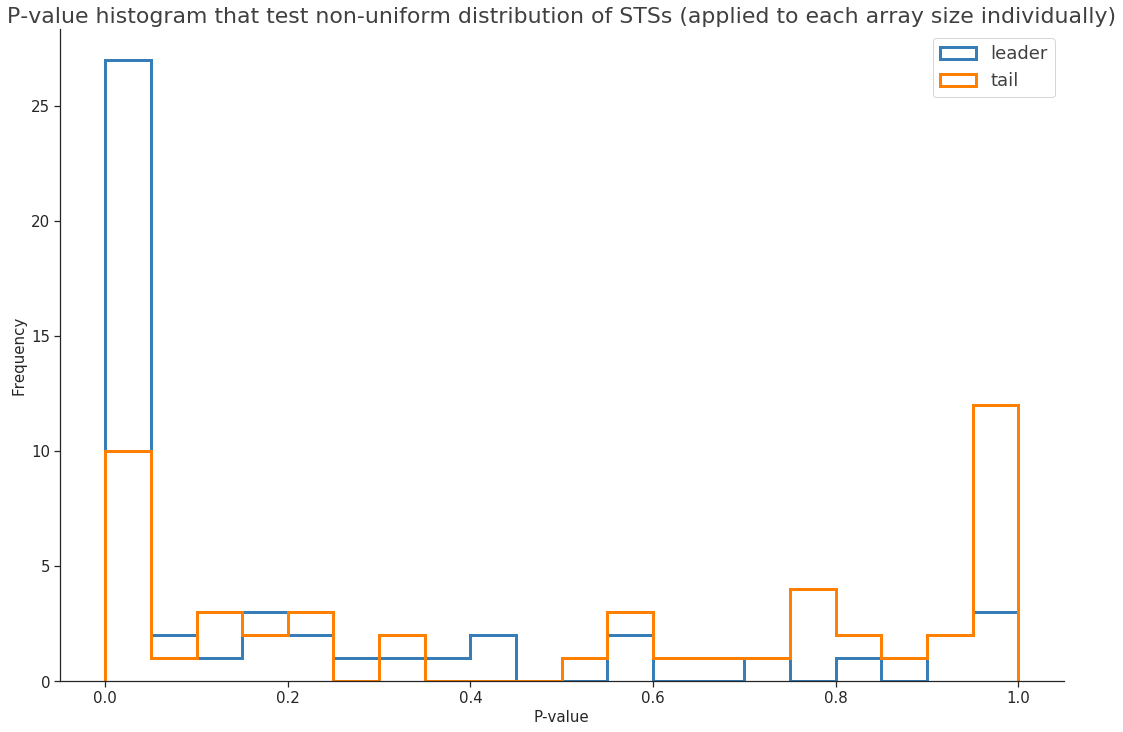

In [36]:
def test_chisquare(tester):
    """Return [leader, middle, tail]"""
    array_size = tester.name
    observed = [tester['leader'], tester['middle'], tester['tail']]
    expected = np.array([1, array_size - 2, 1]) / array_size * sum(observed)
    
    # Hypothesis test applied to each group individually
    p_vals = np.zeros(3)
    for i in range(3):
        mask = np.ones(3, np.bool)
        mask[i] = False
        obs = [observed[~mask][0], expected[mask].sum()]
        exp = [expected[~mask][0], expected[mask].sum()]
        _, p = stats.chisquare(f_obs=obs, f_exp=exp)
        p_vals[i] = p
    return p_vals

def test_binom_test(tester):
    """Return [leader, middle, tail]"""
    array_size = tester.name
    observed = tester[['leader', 'middle', 'tail']]
    n = observed.sum()
    chance = 1 / array_size
    # yields low values if higher than expected
    p_vals = [0] * 3
    for i in [0, 2]:  # Only relevant for leader and tail
        t = observed[i]
        p = stats.binom_test(t, n, chance, 
                             alternative='greater'
                            )
        p_vals[i] = p
    return p_vals

x = 'name_spacer_pos'
hue = 'array_size'
y = 'count'

p_vals = df.pipe(
    lambda d:
    d[x]
    .groupby(d[hue])
    .value_counts(normalize=False)
    .rename(y)
    .reset_index()
    .pivot(index=hue, columns=x, values=y)
    
    .fillna(0)
    .apply(test_binom_test, axis=1, result_type='expand')
    .fillna(0.9)
    .pipe(lambda x: x.set_columns(x.columns.astype(str)))
    .rename({'0':'leader', '1':'middle', '2':'tail'}, axis='columns')
    .loc[2:50, :]  # Too small values afterwards
)
ax = p_vals.drop('middle', axis=1).plot.hist(bins=20,
                                             histtype="step", 
                                             linewidth=3,
                                             alpha=1)

# Observation:
# Unique values hit identity >75% gives a strong tail preference
# High identity hits (not excluding unique) give a strong leader preference

sns.despine()
plt.title("P-value histogram that test non-uniform distribution of STSs (applied to each array size individually)")
plt.xlabel("P-value")
increase_figsize(3)
save_fig()

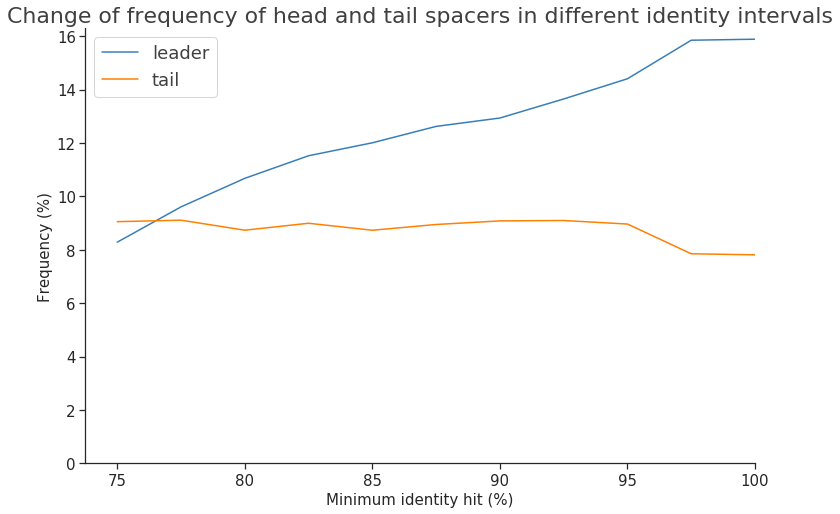

In [57]:
# Cumulative sum to have each range till 100 %
# For each group the percentage of that group is displayed.

pivot_table = df_uni_all.pipe(
    lambda d: 
    d.groupby(['name_spacer_pos', 
                pd.cut(d['hit_ident'], 10)])
    .size() 
    .groupby(level=0).apply(lambda x: x[::-1].cumsum()[::-1]) 
    .groupby(level=1).apply(percentage) 
    .unstack(0).fillna(0)
    .pipe(lambda pt: 
          # Set index to something readable
          pt.set_index(pt.index.map(lambda x: round(x.left, 1)).astype(float))
         )
    .append(
        # Finish table with the group with exactly 100 % identity
        d.query('hit_ident == 100')
        .groupby('name_spacer_pos')
        .size().pipe(percentage)
        .to_frame(100.0).T
    )
    .mul(100)
)

# pd.core.base.PandasObject.reverse = lambda df: df.reindex(index=df.index[::-1])

# sum_ranges = (df_all.groupby(df_all_cut).size()
#               .reverse().cumsum().reverse()
#              )

ax = sns.lineplot(data=pivot_table.drop('middle', axis=1), dashes=False)
sns.despine()
plt.legend(loc='upper left')
ax.set_ylim(bottom=0)
ax.set_xlim(right=100)
ax.set_xlabel('Minimum identity hit (%)')
ax.set_ylabel('Frequency (%)')
ax.set_title('Change of frequency of head and tail spacers in different identity intervals')
increase_figsize(2)
save_fig()

figure saved in /home/hielke/bep/figs/FOR_PUB/A9___Percentage_of_phage_target_(hit_identity:_>90%).png


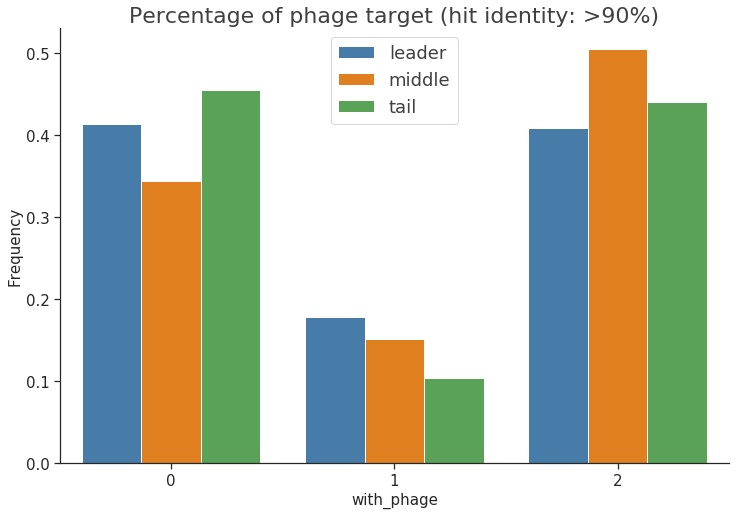

In [38]:
x, y, hue = 'with_phage', 'Frequency', 'name_spacer_pos'
df.pipe(
    lambda d:
    d[x]
    .groupby(d[hue])
    .value_counts(normalize=True)
    .rename(y)
    .reset_index()
).pipe((sns.barplot, "data"), hue=hue, x=x, y=y)
increase_figsize(2)
plt.legend(loc='upper center')
sns.despine()
plt.title("Percentage of phage target (hit identity: %s)" % perc_ident)
save_fig()

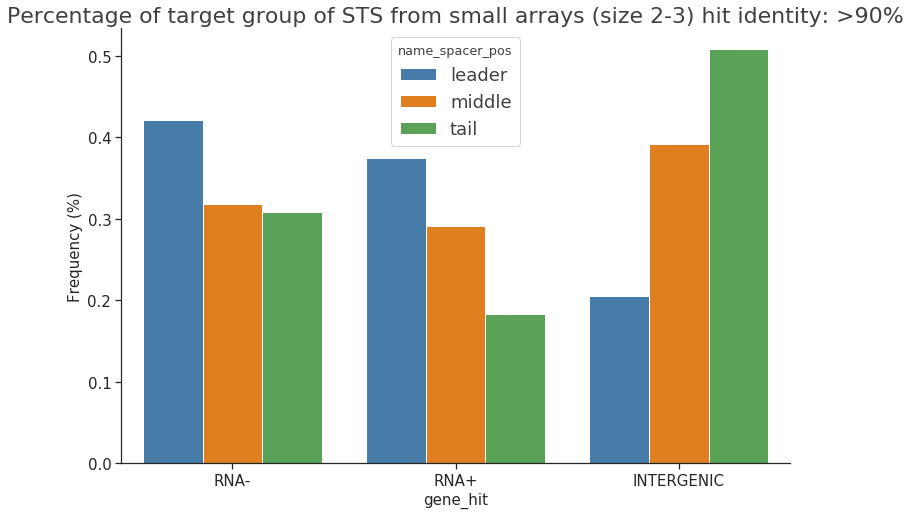

In [88]:
x, y, hue = 'gene_hit', 'Frequency (%)', 'name_spacer_pos'
df.query('array_size < 4').pipe(
    lambda d:
    d[x]
    .groupby(d[hue])
    .value_counts(normalize=True)
    .rename(y)
    .reset_index()
).pipe((sns.barplot, "data"), hue=hue, x=x, y=y)
increase_figsize(2)
sns.despine()
plt.title("Percentage of target group of STS from small arrays (size 2-3) hit identity: %s" % perc_ident)
# plt.legend(loc='upper center')
save_fig()

In [83]:
df.head()

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,array_ori,type,class,num_genes,new_type_group,top_level_group,spacer_pos_rev
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,AACTTCTTCTCCGTGGATTTCGTCGTCACCAT,10514,10484,JQGS01000075,2,JQGS01000093_1_2,96.875,32,17127,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CCTTTATGGA,3,3,2,RNA+,JQGS01000075_22,UNCLASSIFIED,0.045455,middle,mid,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type,22
100053.4,AAGAGGCGATTAGTTGGCTATATGCAGCCTTT,45209,45178,JQGS01000037,8,JQGS01000093_1_8,100.000,32,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTTTACTGA,3,2,2,RNA-,JQGS01000037_64,UNCLASSIFIED,0.318182,middle,mid,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type,16
100053.4,ACGCGCAGAAATATCAGGGTGCTGCCGTTCG,39170,39200,JQGS01000037,23,JQGS01000093_1_23,100.000,31,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTGAGGCGT,3,2,2,RNA+,JQGS01000037_54,UNKNOWN,1.000000,tail,tail,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type,1
100053.4,ATAAGCTCCGATACGCACCAAAGCATCGACTGC,6534,6502,JQGS01000215,5,JQGS01000065_1_5,100.000,33,18044,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,0,TCTTCCGGTG,3,NULL,0,RNA+,JQGS01000215_7,PBS lyase HEAT-like repeat,0.363636,middle,mid,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type,8
100053.4,ATAGCACTCCCCTCATCATGTGTTTCTAATAT,6382,6413,JQGS01000037,15,JQGS01000093_1_15,100.000,32,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTAATTCCA,3,2,2,RNA+,JQGS01000037_11,Phosphoribosyltransferase domain,0.636364,middle,mid,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type,9


In [97]:
x, y, hue, grouper = 'gene_hit', 'Frequency (%)', 'name_spacer_pos', 'top_level_group'
data = df.query('array_size < 4').pipe(
    lambda d:
    d[x]
    .groupby([d[hue], d[grouper],])
#     .value_counts(normalize=True)
#     .rename(y)
#     .reset_index()
)
data.value_counts()

name_spacer_pos  top_level_group  gene_hit  
leader           CRISPR-Type      RNA-          123
                                  RNA+          108
                                  INTERGENIC     33
                 Mixed            RNA+           14
                                  RNA-            8
                                  INTERGENIC      7
                 NOCAS            INTERGENIC     29
                                  RNA-           10
                                  RNA+            4
                 Uncomplete       RNA-            3
                                  RNA+            2
                                  INTERGENIC      1
middle           CRISPR-Type      RNA-           44
                                  RNA+           41
                                  INTERGENIC     23
                 Mixed            RNA-            8
                                  RNA+            6
                                  INTERGENIC      1
                 NO

In [79]:

g = sns.FacetGrid(data=data, hue=hue, row='top_level_group', height=2,)

g = g.map(plt.bar, x, y)

# g.fig.suptitle("Distribution of the totals of unique STSs in a genome (hit identity: %s)" % perc_ident, 
# fontsize=32, y=1.01)
# plt.xlabel('Total STS')
# g.set(yscale='log')
# for ax in g.axes.flat:
#     ax.set_xlim(left=0,
#                right=10,
#                )
# increase_size_by(2, 20)
# g.set_titles(row_template="{row_name}", size=25)
save_fig(g)

KeyError: 'top_level_group'

In [40]:
df.head()

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,array_ori,type,class,num_genes,new_type_group,top_level_group
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,AACTTCTTCTCCGTGGATTTCGTCGTCACCAT,10514,10484,JQGS01000075,2,JQGS01000093_1_2,96.875,32,17127,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CCTTTATGGA,3,3,2,RNA+,JQGS01000075_22,UNCLASSIFIED,0.045455,middle,mid,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type
100053.4,AAGAGGCGATTAGTTGGCTATATGCAGCCTTT,45209,45178,JQGS01000037,8,JQGS01000093_1_8,100.000,32,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTTTACTGA,3,2,2,RNA-,JQGS01000037_64,UNCLASSIFIED,0.318182,middle,mid,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type
100053.4,ACGCGCAGAAATATCAGGGTGCTGCCGTTCG,39170,39200,JQGS01000037,23,JQGS01000093_1_23,100.000,31,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTGAGGCGT,3,2,2,RNA+,JQGS01000037_54,UNKNOWN,1.000000,tail,tail,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type
100053.4,ATAAGCTCCGATACGCACCAAAGCATCGACTGC,6534,6502,JQGS01000215,5,JQGS01000065_1_5,100.000,33,18044,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,0,TCTTCCGGTG,3,NULL,0,RNA+,JQGS01000215_7,PBS lyase HEAT-like repeat,0.363636,middle,mid,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type
100053.4,ATAGCACTCCCCTCATCATGTGTTTCTAATAT,6382,6413,JQGS01000037,15,JQGS01000093_1_15,100.000,32,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTAATTCCA,3,2,2,RNA+,JQGS01000037_11,Phosphoribosyltransferase domain,0.636364,middle,mid,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,CRISPR-Type


Text(0.5, 1.0, 'Spacer position (all spacer hits)')

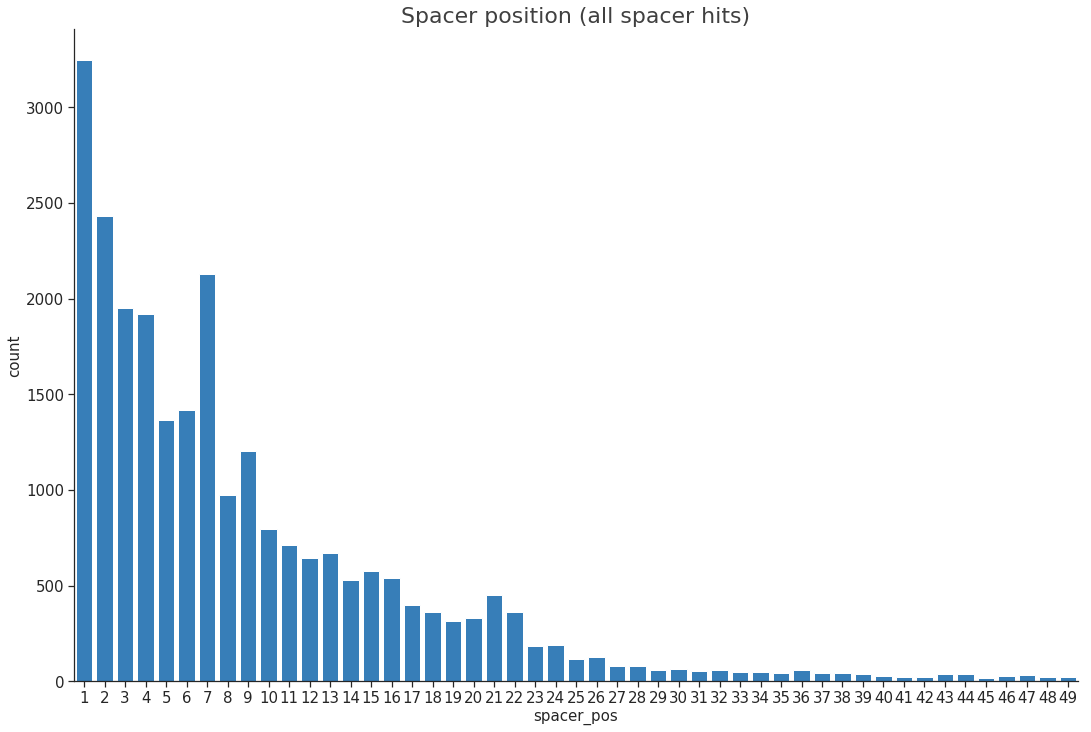

In [41]:
ax = sns.countplot(x='spacer_pos', data=df.query('spacer_pos < 50'), color=cbf[0], saturation=100)
increase_figsize(3)
sns.despine()
plt.title("Spacer position (all spacer hits)" + title_mod)
# save_fig()

Text(0.5, 1.0, 'Spacer position reversed (all spacer hits)')

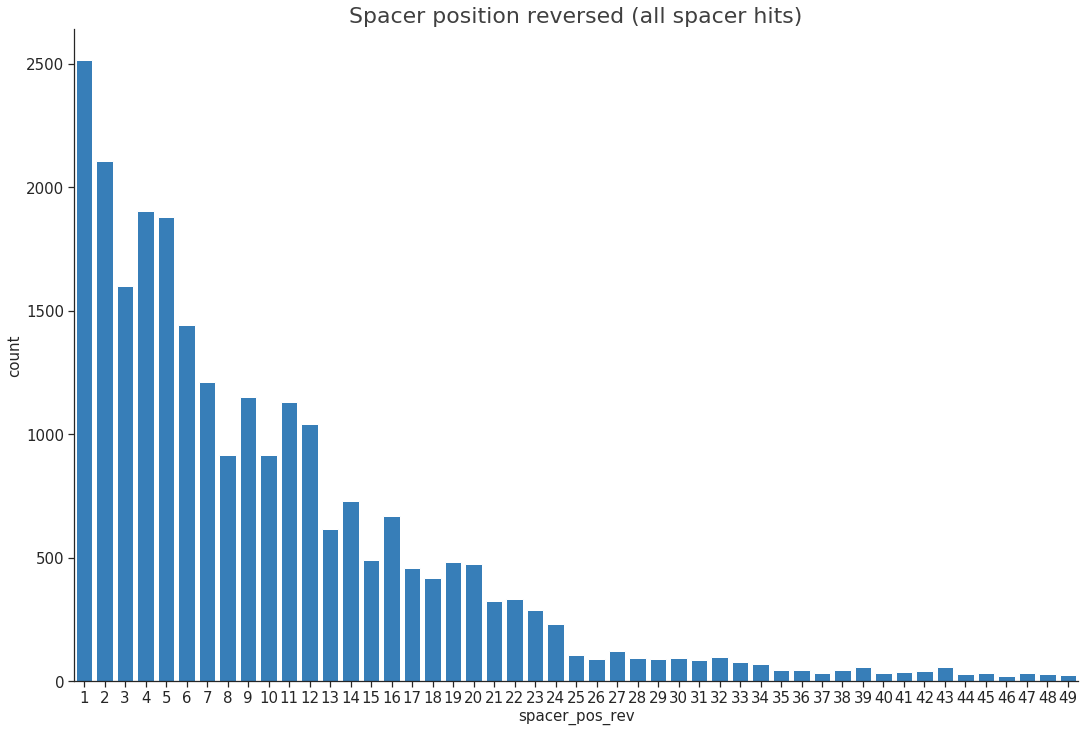

In [42]:
# spacer position reversed
df = df.assign(spacer_pos_rev=df['array_size'].add(1).subtract(df['spacer_pos']))
ax = sns.countplot(x='spacer_pos_rev', data=df.query('spacer_pos_rev < 50'), color=cbf[0], saturation=100)
increase_figsize(3)
sns.despine()
plt.title("Spacer position reversed (all spacer hits)" + title_mod)
# save_fig()

Text(0.5, 1.0, 'Relative spacer position (all spacer hits); 0: leader; 1: tail')

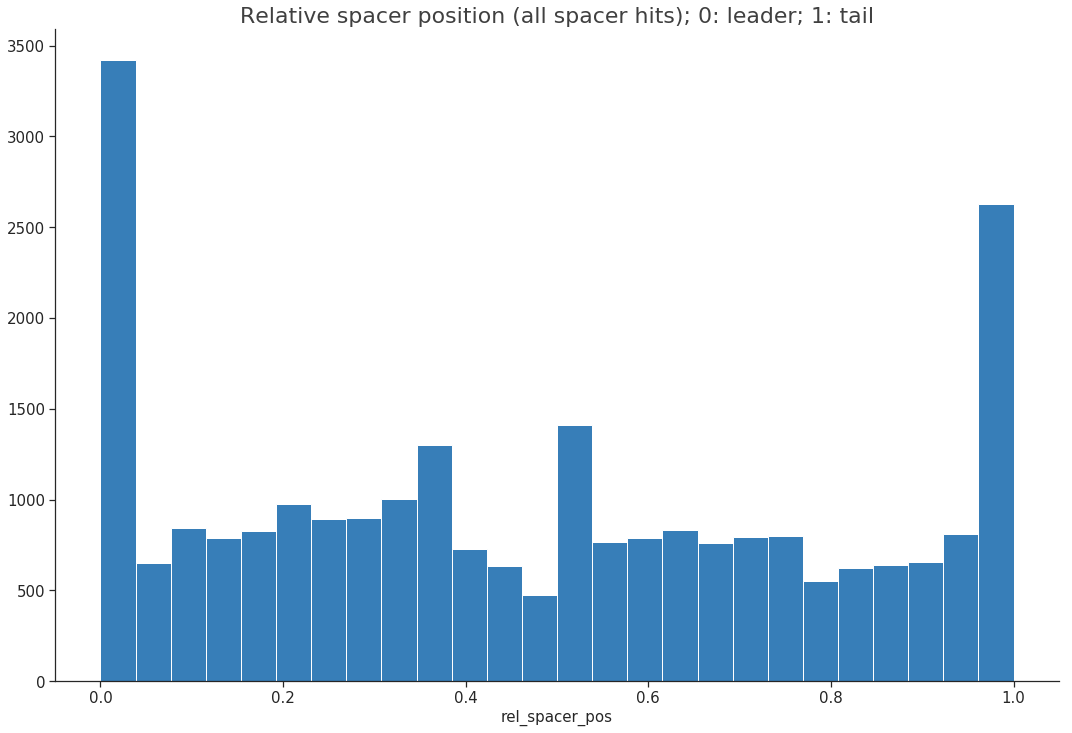

In [43]:
ax = sns.distplot(df['rel_spacer_pos'], kde=False, hist_kws={'color': cbf[0], 'alpha': 1})
increase_figsize(3)
sns.despine()
plt.title("Relative spacer position (all spacer hits); 0: leader; 1: tail" + title_mod)
# save_fig()

[None, None]

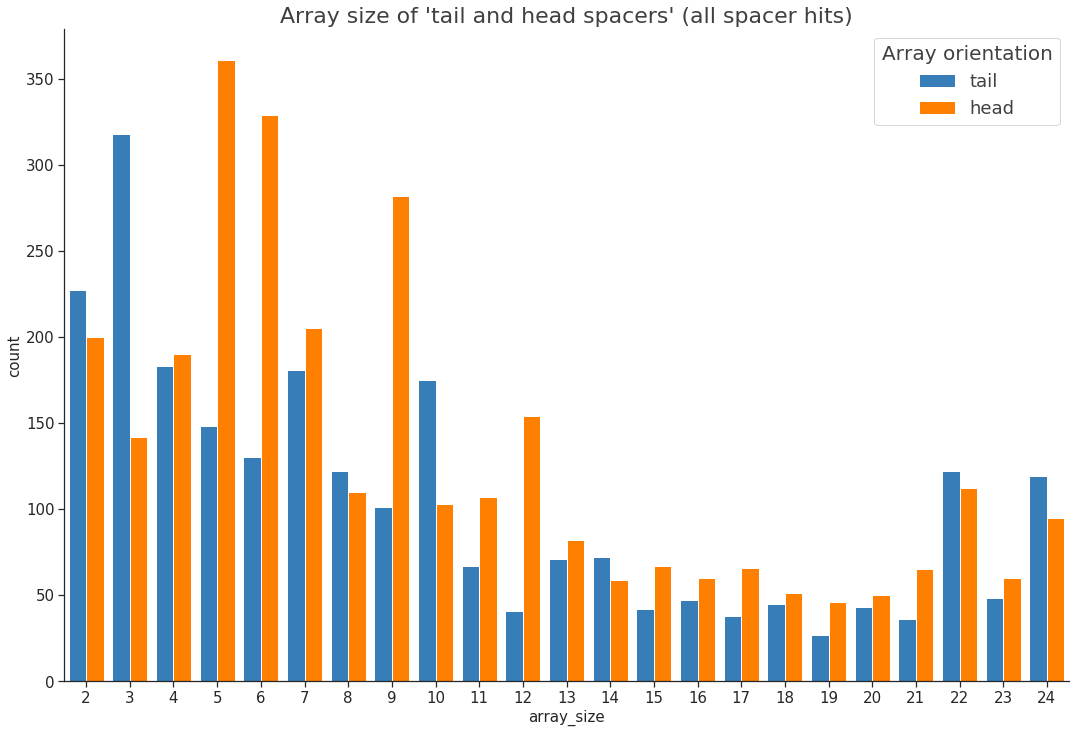

In [44]:
# relative spacer position
ax = sns.countplot(x = 'array_size', data=df.query('array_ori != "mid" and array_size < 25'), 
                   hue='array_ori', saturation=100, palette=cbf)
increase_figsize(3)
sns.despine()
plt.title("Array size of 'tail and head spacers' (all spacer hits)" + title_mod)
plt.setp(ax.get_legend().get_title(), fontsize=20, text="Array orientation")
# save_fig()

figure saved in /home/hielke/bep/figs/FOR_PUB/A11___Identity_with_the_hit.png


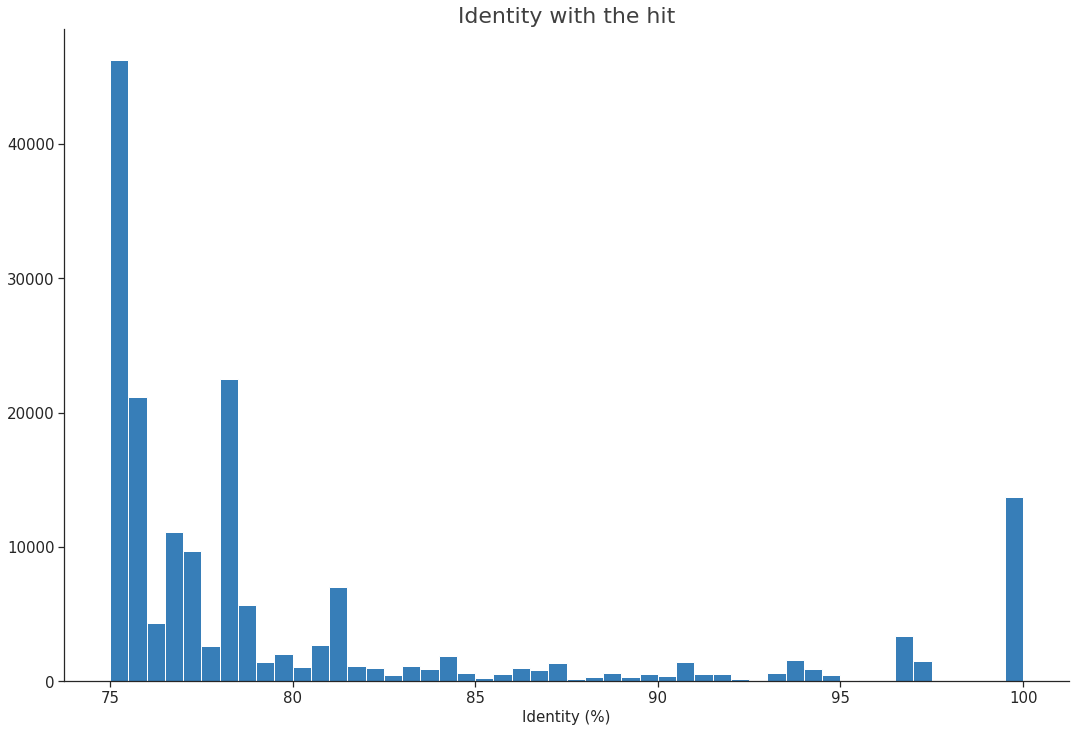

In [45]:
# df_uni_all['hit_ident'] = pd.to_numeric(df_all['hit_ident'])
ax = sns.distplot(df_all['hit_ident'], kde=False, hist_kws={'color': cbf[0], 'alpha': 1})
increase_figsize(3, plt)
sns.despine()
plt.title("Identity with the hit" + title_mod)
plt.xlabel("Identity (%)")
save_fig()

In [46]:
df.groupby(by='genome_id').first()['new_type_group'].value_counts() \
        .pipe(lambda df: df.reindex(sorted(df.index, key=sort_groups)))

CAS-TypeIA           19
CAS-TypeIB         1065
CAS-TypeIC          702
CAS-TypeID           17
CAS-TypeIE         2188
CAS-TypeIF         1527
CAS-TypeIU           46
CAS-TypeIIA         746
CAS-TypeIIB          11
CAS-TypeIIC         580
CAS-TypeIIIA       1154
CAS-TypeIIIB         25
CAS-TypeIIIC          2
CAS-TypeIIID         32
CAS-TypeIV            5
CAS-TypeVA            9
CAS-TypeVB            2
CAS-TypeVIA           4
CAS-TypeVIB1          1
Confirmed Mixed     236
Mixed               469
NOCAS               806
Uncomplete          182
Name: new_type_group, dtype: int64

figure saved in /home/hielke/bep/figs/FOR_PUB/A12___Frequency_of_all_STS_per_type_(hit_identity:_>90%).png


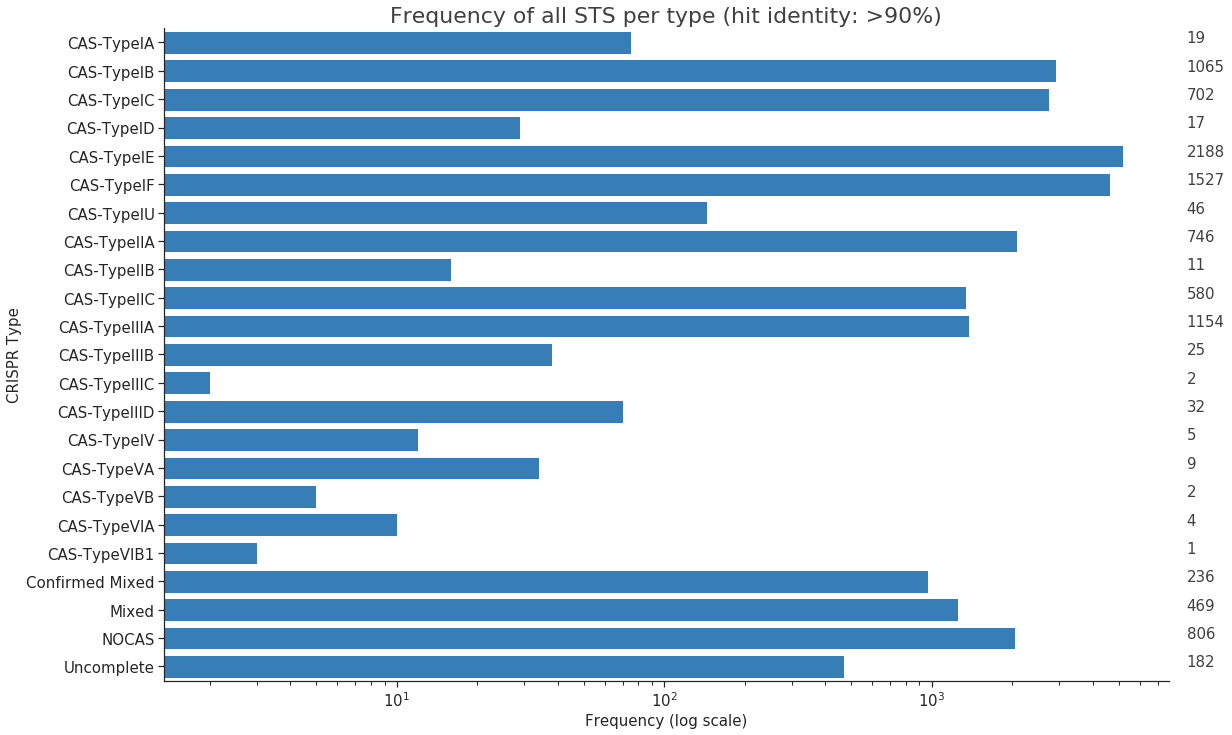

In [47]:
def plot(df, y):
    genome_value_counts = df.groupby(by='genome_id').first()[y].value_counts() \
        .pipe(lambda d: d.reindex(sorted(d.index, key=sort_groups)))
    ax = sns.countplot(y=y, data=df, color=cbf[0], saturation=100, 
                   order=sorted(df[y].unique(), key=sort_groups))
    N = len(genome_value_counts)
    ind = list(range(N))
    for i, v in enumerate(genome_value_counts):
        if v == 0: continue
        ax.text(9000, ind[i], str(round(v)), color='0.25', fontsize=15)
    return ax
ax = plot(df, 'new_type_group')
ax.set_xscale('log')
increase_figsize(3, plt)
sns.despine()
plt.title("Frequency of all STS per type (hit identity: %s)" % perc_ident + title_mod)
plt.xlabel("Frequency (log scale)")
plt.ylabel("CRISPR Type")
save_fig()

Text(0, 0.5, 'CRISPR Type')

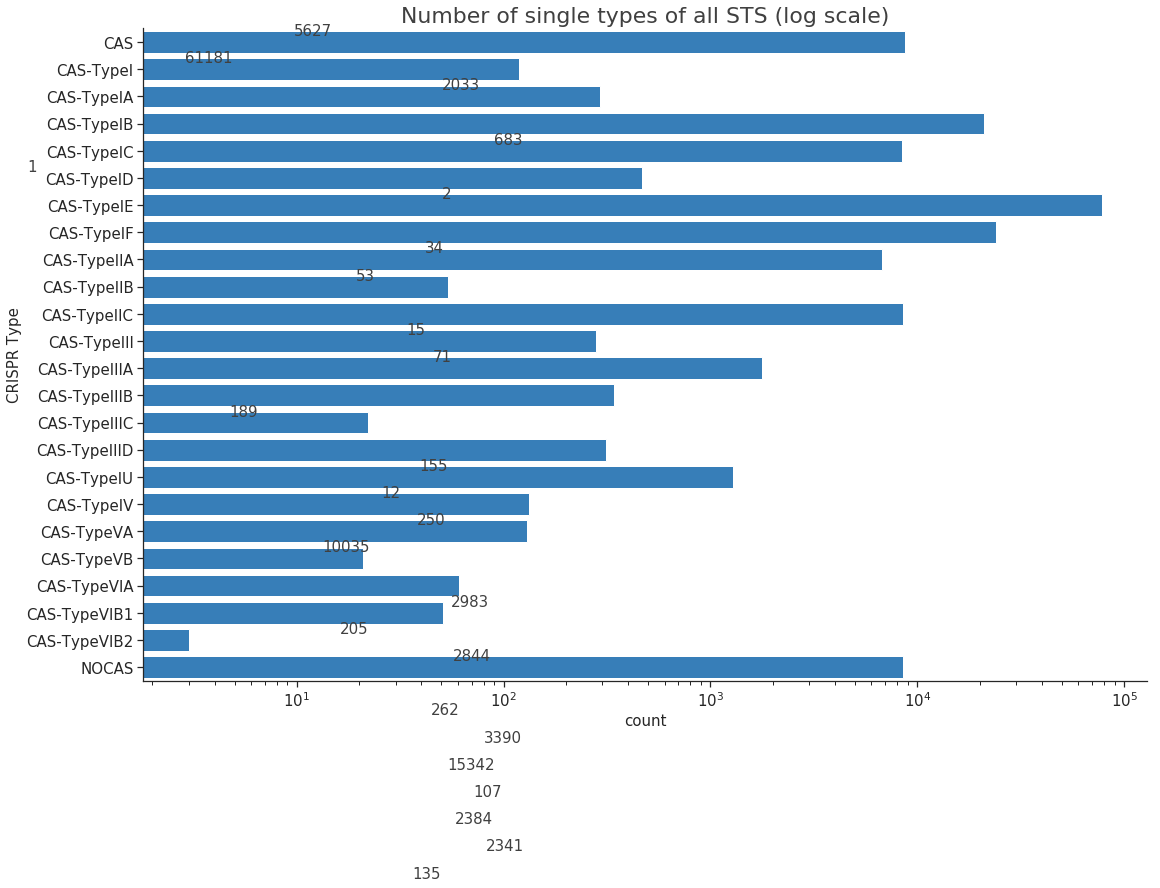

In [48]:
ax = sns.countplot(y='genome_type', 
                   data=df_single_type, color=cbf[0], 
                   saturation=100, 
                   order=sorted(df_single_type['genome_type'].unique()))
ax.set_xscale('log')
for i, v in enumerate(all_genome_type_count):
    if v == 0: continue
    ax.text(value_counts_perc[i]+0.5, ind[i]-0.25, str(round(v)), color='0.25', fontsize=15)

increase_figsize(3)
sns.despine()
plt.title("Number of single types of all STS (log scale)" + title_mod)
plt.ylabel("CRISPR Type")
# save_fig()

In [49]:
pivot_table = df_single_type.groupby(['genome_type', pd.cut(df_single_type['hit_ident'], 10)]).size() \
        .groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
pivot_table

hit_ident,"(74.976, 77.501]","(77.501, 80.0]","(80.0, 82.5]","(82.5, 85.0]","(85.0, 87.5]","(87.5, 90.0]","(90.0, 92.5]","(92.5, 95.0]","(95.0, 97.5]","(97.5, 100.0]"
genome_type,,,,,,,,,,
CAS,50.353720,15.609311,6.754906,3.035144,2.909630,2.156550,2.236422,2.749886,3.286171,10.908261
CAS-TypeI,36.440678,7.627119,12.711864,29.661017,4.237288,4.237288,0.847458,0.847458,3.389831,0.000000
CAS-TypeIA,41.095890,14.383562,7.191781,5.136986,1.712329,4.794521,4.794521,5.136986,2.054795,13.698630
CAS-TypeIB,50.765791,16.309932,8.556887,4.085807,3.814688,2.330670,2.311644,2.273592,2.254566,7.296423
CAS-TypeIC,38.609027,13.778730,6.549958,2.715255,2.834346,2.917709,4.156246,3.310706,5.823508,19.304514
CAS-TypeID,52.360515,23.390558,11.587983,3.862661,1.287554,0.643777,0.643777,0.858369,1.072961,4.291845
CAS-TypeIE,58.269818,23.518618,8.101727,2.024790,1.093233,0.292555,0.818641,1.106064,1.474324,3.300228
CAS-TypeIF,46.399036,21.410464,6.379088,3.569796,2.435274,0.295059,2.530857,2.896563,4.550555,9.533308
CAS-TypeIIA,40.634779,6.422292,5.245120,5.215318,6.243481,5.081210,2.190434,5.826255,7.882581,15.258531


Text(0.5, 1.0, 'Heatmap of identity with hit')

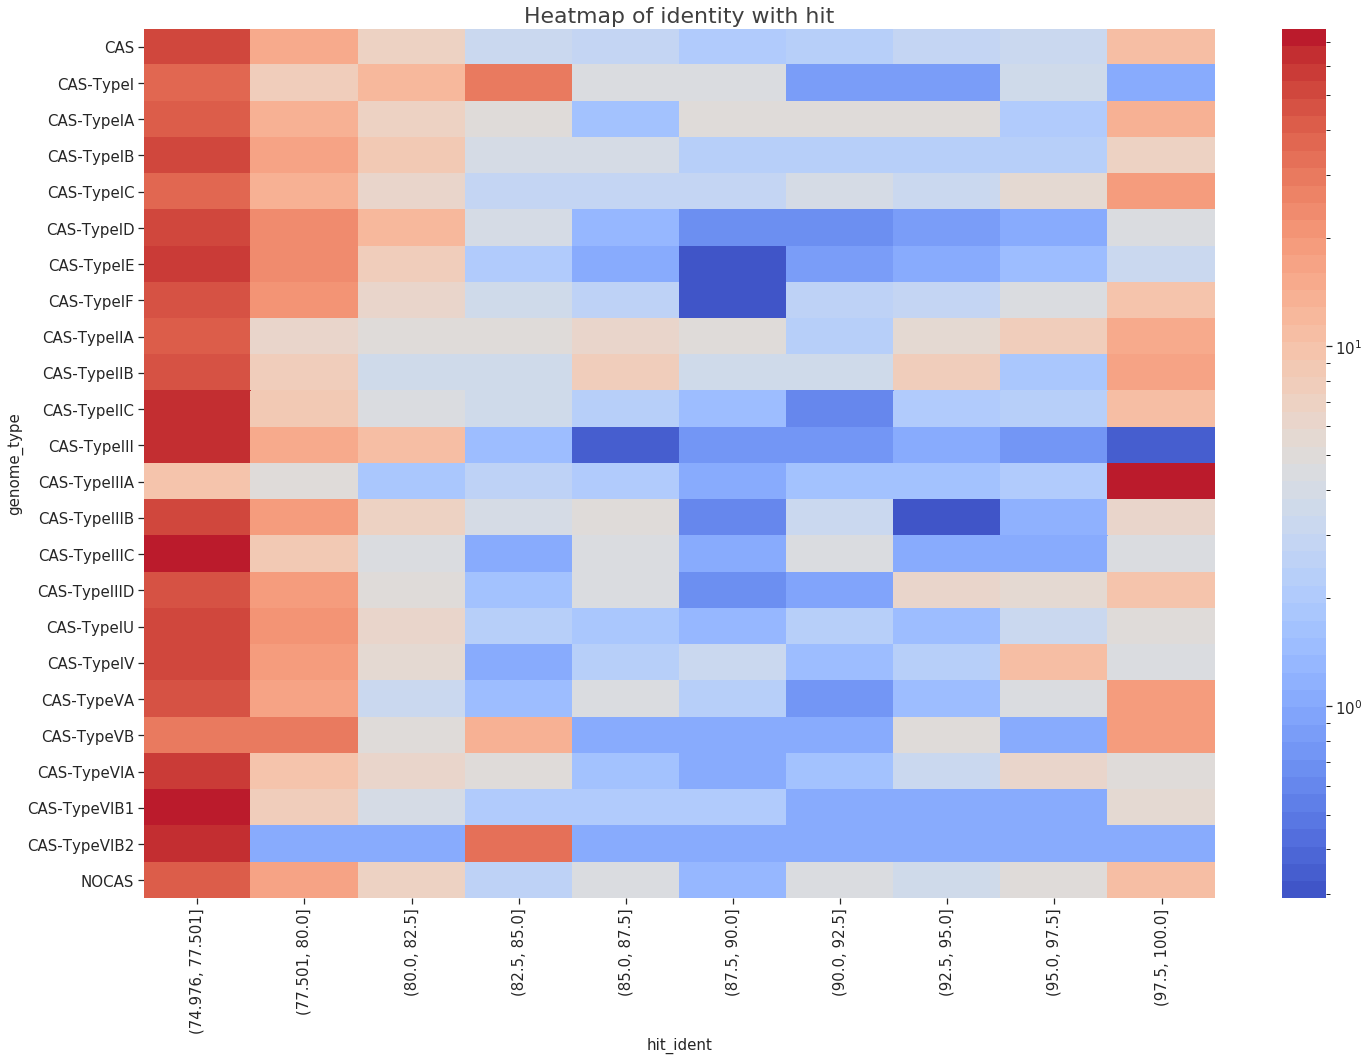

In [50]:
ax = sns.heatmap(pivot_table.where(pivot_table!=0, 1e0), yticklabels=True, xticklabels=True, square=False, 
            cmap=sns.color_palette("coolwarm", 50), 
            cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
            norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
increase_figsize(4, plt)
plt.title("Heatmap of identity with hit" + title_mod)
# save_fig()

In [51]:
pivot_table = df_single_type.groupby(
    ['genome_type', pd.cut(df_single_type['array_size'], 
    pd.IntervalIndex.from_breaks(list(range(0,80,5)) + [400]))]).size() \
        .groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
pivot_table

array_size,"(0, 5]","(5, 10]","(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]","(35, 40]","(40, 45]","(45, 50]","(50, 55]","(55, 60]","(60, 65]","(65, 70]","(70, 75]","(75, 400]"
genome_type,,,,,,,,,,,,,,,,
CAS,6.469649,17.400730,12.676860,16.453674,17.104062,4.803743,3.822455,3.137837,3.000913,1.061159,1.198083,0.787312,1.049749,1.654496,1.232314,8.146965
CAS-TypeI,5.084746,9.322034,12.711864,16.101695,22.881356,33.898305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CAS-TypeIA,3.767123,14.041096,13.013699,32.534247,12.328767,0.684932,5.479452,2.054795,0.342466,6.164384,0.000000,0.000000,1.712329,0.000000,0.000000,7.876712
CAS-TypeIB,5.441400,19.991438,19.311263,15.715373,14.597603,8.875571,3.253425,2.692161,3.676750,0.689688,0.646880,1.935883,0.166476,0.394787,0.361492,2.249810
CAS-TypeIC,9.955937,14.755270,8.776944,11.218292,23.151125,3.501250,2.667619,2.536620,1.619626,1.857806,2.346076,1.333810,2.524711,1.286174,1.226629,11.242110
CAS-TypeID,4.935622,9.012876,7.296137,5.793991,5.579399,6.437768,0.858369,4.935622,3.648069,4.935622,0.643777,0.000000,0.214592,0.643777,2.145923,42.918455
CAS-TypeIE,7.416532,15.017836,15.112788,11.448148,20.596915,5.920394,4.863089,4.719378,3.654374,3.087228,1.585957,1.067570,1.286986,0.346447,0.591526,3.284831
CAS-TypeIF,6.549474,12.812201,17.159124,13.905166,37.917134,0.864398,1.034784,0.673233,0.585962,0.789594,0.843619,0.677389,1.014005,0.349084,0.502847,4.321988
CAS-TypeIIA,10.266726,18.730443,15.139323,12.948890,15.511846,6.303084,7.852779,4.231858,3.218596,2.354344,1.341082,0.640739,0.163910,0.804649,0.089405,0.402325


Text(0.5, 1.0, 'Heatmap of array size')

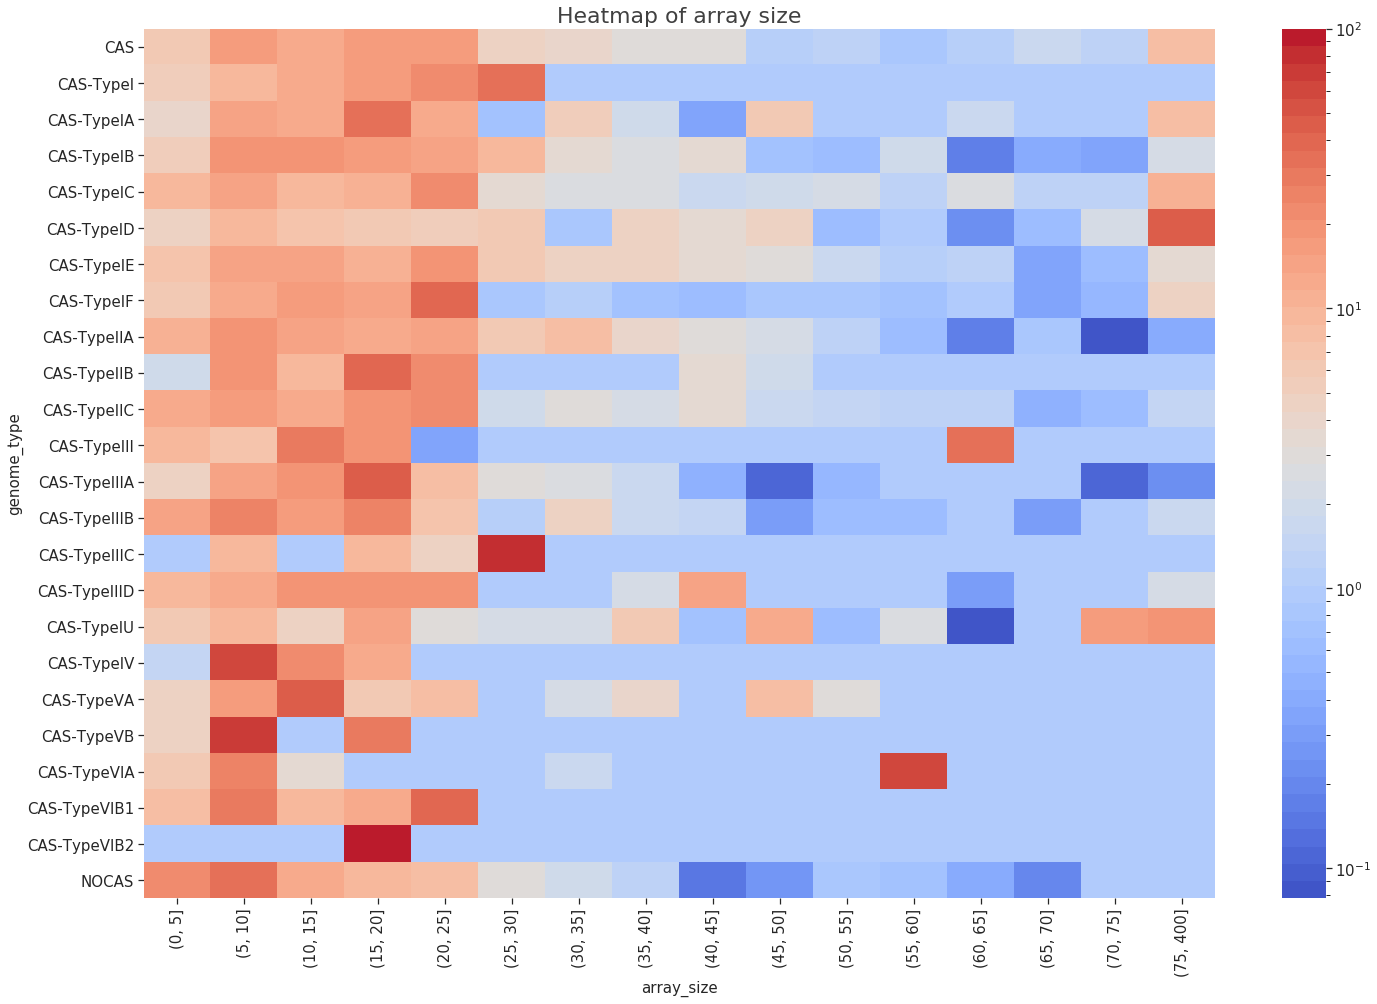

In [52]:
ax = sns.heatmap(pivot_table.where(pivot_table!=0, 1e0), yticklabels=True, xticklabels=True, square=False, 
            cmap=sns.color_palette("coolwarm", 50), 
            cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
            norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
increase_figsize(4, plt)
plt.title("Heatmap of array size" + title_mod)
# save_fig()

Text(0.5, 1.0, 'Heatmap of spacer position')

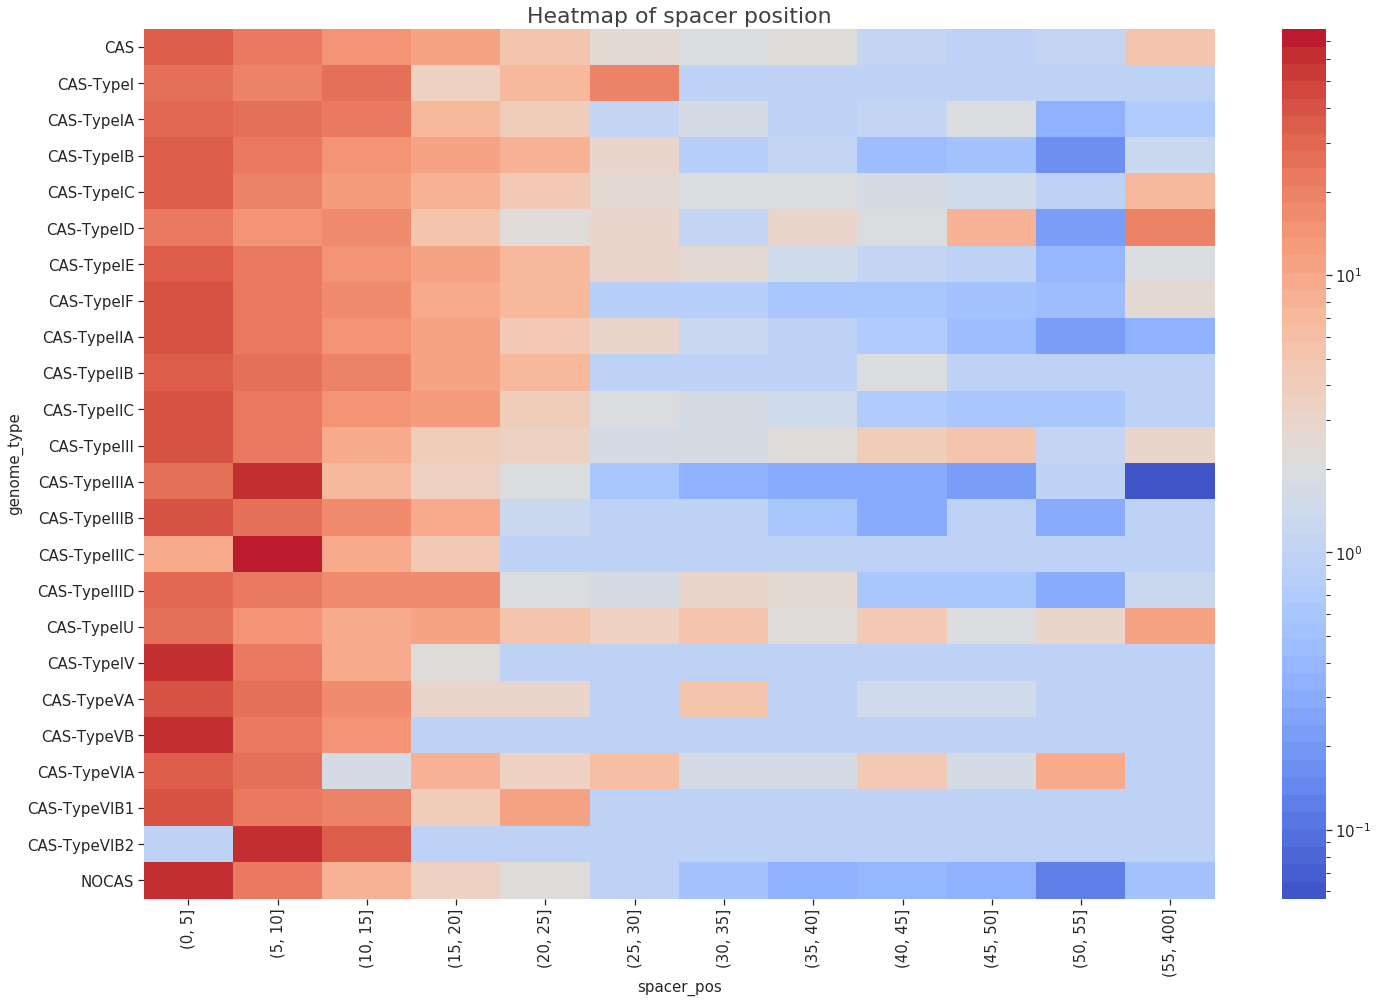

In [53]:
pivot_table = df_single_type.groupby(
    ['genome_type', pd.cut(df_single_type['spacer_pos'], 
    pd.IntervalIndex.from_breaks(list(range(0,60,5)) + [400]))]).size() \
        .groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
pivot_table
ax = sns.heatmap(pivot_table.where(pivot_table!=0, 1e0), yticklabels=True, xticklabels=True, square=False, 
            cmap=sns.color_palette("coolwarm", 50), 
            cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
            norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
increase_figsize(4, plt)
plt.title("Heatmap of spacer position" + title_mod)
# save_fig()

In [54]:
# pivot_table = df_single_type.groupby(
#     ['genome_type', pd.cut(df_single_type['rel_spacer_pos'], 
#     pd.IntervalIndex.from_breaks(list(map(lambda x: -.01 if x==0 else round(0.01*x, 2), range(0,110,5)))))
#                            ]).size() \
#         .groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
# pivot_table
# ax = sns.heatmap(pivot_table.where(pivot_table!=0, 1e0), yticklabels=True, xticklabels=True, square=False, 
#             cmap=sns.color_palette("coolwarm", 50), 
#             cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
#             norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
# increase_figsize(4, plt)
# plt.title("Heatmap of relative spacer position (0: leader; 1: tail)" + title_mod)
# if False or save: plt.savefig(fig_folder + first_order + str(second_order) + ax.get_title().replace(" ", "_") + ".png", format='png', bbox_inches='tight')

figure saved in /home/hielke/bep/figs/FOR_PUB/A13___Hits_in_genes_(hit_identity:_>90%).png


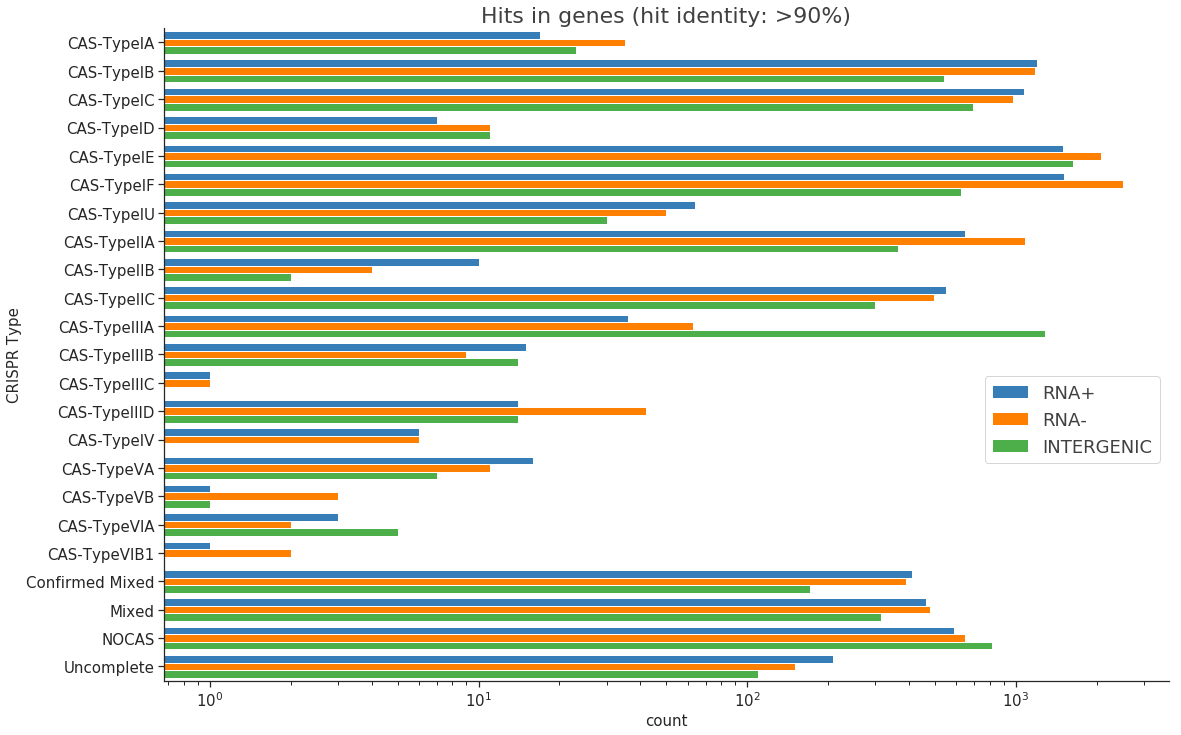

In [55]:
# df_single_type = df[~df['genome_type'].str.contains('/')]
ax = sns.countplot(y='new_type_group', hue='gene_hit', data=df, 
                   saturation=100, palette=cbf, order=sorted(df['new_type_group'].unique(), key=sort_groups))
ax.set_xscale('log')
increase_figsize(3)
plt.legend(loc='center right', bbox_to_anchor=(1, .4))
sns.despine()
# plt.setp(ax.get_legend().get_title(), fontsize=20, text=None)
plt.ylabel("CRISPR Type")
plt.title("Hits in genes (hit identity: %s)" % perc_ident + title_mod,)
save_fig()